In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from itertools import cycle

import seaborn as sns
import matplotlib.pyplot as plt

import shap
shap.initjs()  # Initialize JavaScript visualization support

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/ekkirinaldi/Documents/Git/ai-bearing-toto/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


./crwu-bearings-benchmarks-shap-explainability.ipynb
./ID-crwu-bearings-benchmarks-shap-explainability.ipynb.backup
./CWRU_48k_load_1_CNN_data.npz
./ID-crwu-bearings-benchmarks-shap-explainability.ipynb
./feature_time_48k_2048_load_1.csv
./raw/OR007_6_1_136.mat
./raw/OR021_6_1_239.mat
./raw/Time_Normal_1_098.mat
./raw/IR021_1_214.mat
./raw/IR014_1_175.mat
./raw/IR007_1_110.mat
./raw/B021_1_227.mat
./raw/B014_1_190.mat
./raw/B007_1_123.mat
./raw/OR014_6_1_202.mat


## Ringkasan Eksekutif

Notebook ini mengimplementasikan analisis eksplainabilitas SHAP yang komprehensif untuk deteksi kerusakan bearing menggunakan Dataset Bearing CWRU.

**Ringkasan Dataset:**
- **Total Sampel**: 2.300 sampel dari 10 kelas kerusakan
- **Sampel per Kelas**: 230 sampel per jenis kerusakan (seimbang sempurna)
- **Pembagian Train-Test**: 1.550 sampel training (67,4%) / 750 sampel testing (32,6%)
- **Fitur**: 9 fitur statistik yang diekstrak dari sinyal getaran domain waktu

**Performa Model (Set Test Lengkap - 750 sampel):**
- **SVC (Model Terbaik)**: Akurasi 96,4% (723/750 benar, 27 kesalahan klasifikasi)
- **Regresi Logistik**: Akurasi 94,3% (707/750 benar, 43 kesalahan klasifikasi)
- **Rata-rata ROC-AUC**: 0,731 (SVC), 0,656 (LR)
- **Rata-rata PR-AUC**: 0,623 (SVC), 0,606 (LR)

**Analisis SHAP:**
- Analisis eksplainabilitas SHAP dilakukan pada subset 200 sampel untuk efisiensi komputasi
- Akurasi subset SHAP: 98% (196/200 benar, 4 kesalahan klasifikasi)
- Penjelasan global dan lokal disediakan untuk model SVC dan Regresi Logistik

**Wawasan Utama:**
- Crest factor dan nilai minimum paling diskriminatif untuk model SVC
- Amplitudo rata-rata mendominasi dalam Regresi Logistik
- Hanya Mean dan Kurtosis yang muncul di 5 fitur teratas untuk kedua model
- Pola spesifik kerusakan mengungkapkan strategi pemantauan yang berbeda diperlukan untuk kerusakan Inner Race vs Outer Race vs Ball


## Alur Kerja Penelitian

Diagram berikut menjelaskan alur kerja penelitian dari data mentah hingga interpretasi hasil:

```
┌─────────────────────────────────────────────────────────────────┐
│                    DATA PREPROCESSING                           │
│  Raw Vibration Signals (.mat files)                             │
│         ↓                                                       │
│  Feature Extraction (Time-domain)                               │
│  - max, min, mean, sd, rms, skewness, kurtosis, crest, form     │
│         ↓                                                       │
│  CSV Dataset (2300 samples × 10 features)                       │
└─────────────────────────────────────────────────────────────────┘
                            ↓
┌─────────────────────────────────────────────────────────────────┐
│                    DATA EXPLORATION                             │
│  - Dataset shape & statistics                                   │
│  - Class distribution (10 fault types)                          │
│  - Feature statistics                                           │
└─────────────────────────────────────────────────────────────────┘
                            ↓
┌─────────────────────────────────────────────────────────────────┐
│                    DATA PREPARATION                             │
│  Train-Test Split (1550 train / 750 test)                       │
│         ↓                                                       │
│  Feature Scaling (StandardScaler)                               │
└─────────────────────────────────────────────────────────────────┘
                            ↓
┌─────────────────────────────────────────────────────────────────┐
│                    MODEL TRAINING                               │
│  ┌──────────────────────┐  ┌──────────────────────┐             │
│  │  SVC Baseline        │  │  Logistic Regression │             │
│  │  (untuned)           │  │  (baseline)          │             │
│  └──────────────────────┘  └──────────────────────┘             │
│         ↓                                                       │
│  ┌──────────────────────┐                                       │
│  │  GridSearchCV        │                                       │
│  │  (Hyperparameter     │                                       │
│  │   Tuning for SVC)    │                                       │
│  └──────────────────────┘                                       │
│         ↓                                                       │
│  Best SVC Model (optimized)                                     │
└─────────────────────────────────────────────────────────────────┘
                            ↓
┌─────────────────────────────────────────────────────────────────┐
│                    MODEL EVALUATION                             │
│  - Confusion Matrix                                             │
│  - Classification Report                                        │
│  - ROC Curves (combined SVC & LR)                               │
│  - Precision-Recall Curves (combined SVC & LR)                  │
└─────────────────────────────────────────────────────────────────┘
                            ↓
┌─────────────────────────────────────────────────────────────────┐
│                    SHAP EXPLAINABILITY                          │
│  ┌──────────────────────┐  ┌──────────────────────┐             │
│  │  SVC Model           │  │  Logistic Regression │             │
│  │  KernelExplainer     │  │  LinearExplainer     │             │
│  │  (200 samples)       │  │  (200 samples)       │             │
│  └──────────────────────┘  └──────────────────────┘             │
│         ↓                        ↓                              │
│  ┌──────────────────────────────────────────┐                   │
│  │  SHAP Analysis                           │                   │
│  │  - Global Feature Importance (Summary)   │                   │
│  │  - Local Explanations (Waterfall, 2 ex)  │                   │
│  │  - Model Comparison                      │                   │
│  │  - Fault-Specific Analysis               │                   │
│  └──────────────────────────────────────────┘                   │
└─────────────────────────────────────────────────────────────────┘
                            ↓
┌─────────────────────────────────────────────────────────────────┐
│                    INTERPRETATION & FINDINGS                    │
│  - Key Feature Insights                                         │
│  - Model Comparison Insights                                    │
│  - Fault-Specific Patterns                                      │
│  - Misclassification Analysis                                   │
└─────────────────────────────────────────────────────────────────┘
```

**Catatan Penting:**
- Analisis SHAP menggunakan subset 200 sampel untuk efisiensi komputasi (KernelExplainer untuk SVC memerlukan waktu yang lama)
- Evaluasi model final menggunakan seluruh 750 sampel test set
- Semua visualisasi SHAP dikonsolidasikan menjadi 3-4 plot kunci untuk kejelasan


## Identifikasi Jenis Kerusakan
Terdapat 10 jenis kerusakan yang terkait dengan setiap cacat bearing:

- **Ball_007_1**: Cacat pada bola (0.007 inci)
- **Ball_014_1**: Cacat pada bola (0.014 inci)
- **Ball_021_1**: Cacat pada bola (0.021 inci)
- **IR_007_1**: Kerusakan inner race (0.007 inci)
- **IR_014_1**: Kerusakan inner race (0.014 inci)
- **IR_021_1**: Kerusakan inner race (0.021 inci)
- **Normal_1**: Normal
- **OR_007_6_1**: Kerusakan outer race (0.007 inci, data dikumpulkan dari posisi jam 6)
- **OR_014_6_1**: Kerusakan outer race (0.014 inci, jam 6)
- **OR_021_6_1**: Kerusakan outer race (0.021 inci, jam 6)

## Mengambil Data
File yang akan kita baca adalah hasil preprocessing dari file data mentah (folder `raw/`).

Segmen time series berisi 2048 titik masing-masing. Mengingat frekuensi sampling adalah 48kHz, setiap time series mencakup 0.04 detik.

In [2]:
data_time = pd.read_csv("feature_time_48k_2048_load_1.csv")
data_time

,max,min,mean,sd,rms,skewness,kurtosis,crest,form,fault
0,0.35986,-0.41890,0.017840,0.122746,0.124006,-0.118571,-0.042219,2.901946,6.950855,Ball_007_1
1,0.46772,-0.36111,0.022255,0.132488,0.134312,0.174699,-0.081548,3.482334,6.035202,Ball_007_1
2,0.46855,-0.43809,0.020470,0.149651,0.151008,0.040339,-0.274069,3.102819,7.376926,Ball_007_1
3,0.58475,-0.54303,0.020960,0.157067,0.158422,-0.023266,0.134692,3.691097,7.558387,Ball_007_1
4,0.44685,-0.57891,0.022167,0.138189,0.139922,-0.081534,0.402783,3.193561,6.312085,Ball_007_1
...,...,...,...,...,...,...,...,...,...,...
2295,0.21425,-0.19839,0.010769,0.064100,0.064983,-0.212497,-0.119312,3.297037,6.034174,Normal_1
2296,0.21967,-0.20882,0.013136,0.068654,0.069883,-0.061308,-0.295122,3.143410,5.319958,Normal_1
2297,0.20799,-0.21613,0.012571,0.067128,0.068279,-0.154754,-0.071405,3.046161,5.431299,Normal_1
2298,0.21425,-0.22405,0.012608,0.066813,0.067977,-0.326966,0.023662,3.151821,5.391672,Normal_1


## Analisis Data Eksploratif (EDA)

Mari kita eksplorasi dataset untuk memahami distribusi fitur, korelasi, dan keseimbangan kelas.


In [3]:
# Basic dataset information
print("Dataset shape:", data_time.shape)
print("\nColumn names:", data_time.columns.tolist())
print("\nData types:")
print(data_time.dtypes)
print("\nMissing values:")
print(data_time.isnull().sum().sum())
print("\nFirst few rows:")
data_time.head()


Dataset shape: (2300, 10)

Column names: ['max', 'min', 'mean', 'sd', 'rms', 'skewness', 'kurtosis', 'crest', 'form', 'fault']

Data types:
max         float64
min         float64
mean        float64
sd          float64
rms         float64
skewness    float64
kurtosis    float64
crest       float64
form        float64
fault        object
dtype: object

Missing values:
0

First few rows:


,max,min,mean,sd,rms,skewness,kurtosis,crest,form,fault
0,0.35986,-0.41890,0.017840,0.122746,0.124006,-0.118571,-0.042219,2.901946,6.950855,Ball_007_1
1,0.46772,-0.36111,0.022255,0.132488,0.134312,0.174699,-0.081548,3.482334,6.035202,Ball_007_1
2,0.46855,-0.43809,0.020470,0.149651,0.151008,0.040339,-0.274069,3.102819,7.376926,Ball_007_1
3,0.58475,-0.54303,0.020960,0.157067,0.158422,-0.023266,0.134692,3.691097,7.558387,Ball_007_1
4,0.44685,-0.57891,0.022167,0.138189,0.139922,-0.081534,0.402783,3.193561,6.312085,Ball_007_1


Fault type distribution:
fault
Ball_007_1    230
Ball_014_1    230
Ball_021_1    230
IR_007_1      230
IR_014_1      230
IR_021_1      230
Normal_1      230
OR_007_6_1    230
OR_014_6_1    230
OR_021_6_1    230
Name: count, dtype: int64

Total samples: 2300


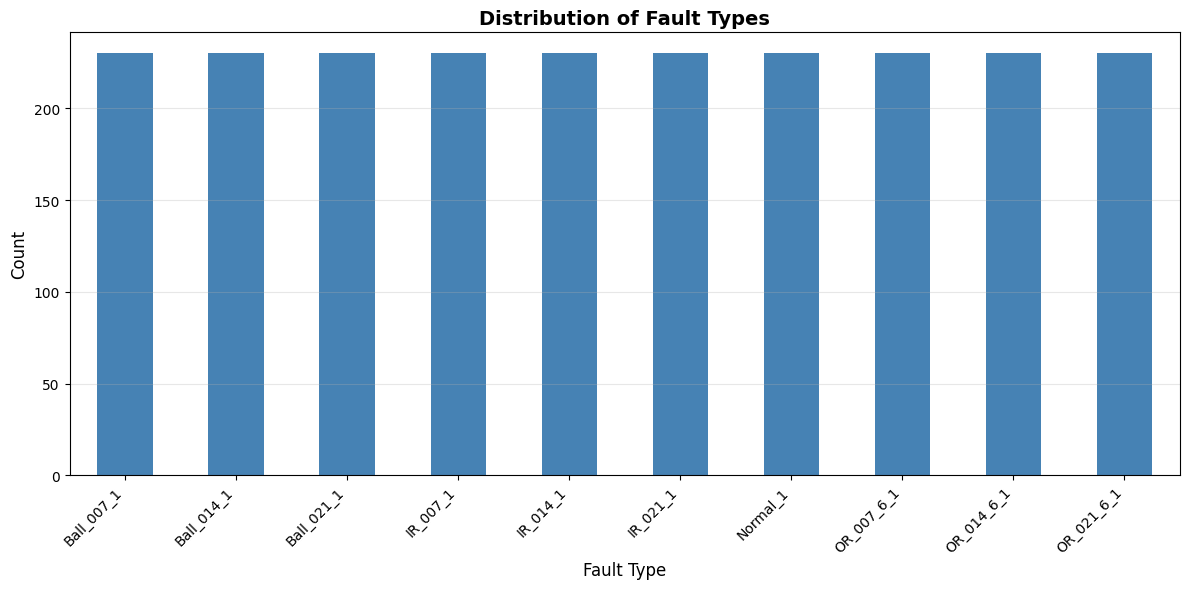

In [4]:
# Class distribution
fault_counts = data_time['fault'].value_counts().sort_index()
print("Fault type distribution:")
print(fault_counts)
print(f"\nTotal samples: {len(data_time)}")

plt.figure(figsize=(12, 6))
fault_counts.plot(kind='bar', color='steelblue')
plt.title('Distribution of Fault Types', fontsize=14, fontweight='bold')
plt.xlabel('Fault Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


**Interpretasi Chart Distribusi Kelas:**

Chart di atas menunjukkan distribusi sampel untuk setiap jenis kerusakan bearing. Hasil menunjukkan bahwa dataset **seimbang sempurna** dengan 230 sampel untuk setiap dari 10 jenis kerusakan:

- **3 jenis kerusakan Ball** (Ball_007_1, Ball_014_1, Ball_021_1) dengan tingkat keparahan berbeda
- **3 jenis kerusakan Inner Race** (IR_007_1, IR_014_1, IR_021_1) dengan tingkat keparahan berbeda  
- **3 jenis kerusakan Outer Race** (OR_007_6_1, OR_014_6_1, OR_021_6_1) dengan tingkat keparahan berbeda
- **1 kelas Normal** (Normal_1)

Keseimbangan dataset ini penting untuk pelatihan model yang adil dan menghindari bias terhadap kelas mayoritas. Dengan distribusi yang seimbang, model dapat belajar dengan baik untuk semua jenis kerusakan.


In [5]:
# Feature statistics
feature_cols = data_time.columns[:-1]  # All columns except 'fault'
print("Feature statistics:")
print(data_time[feature_cols].describe())


Feature statistics:
               max          min         mean           sd          rms  \
count  2300.000000  2300.000000  2300.000000  2300.000000  2300.000000   
mean      1.575079    -1.550994     0.015711     0.341601     0.342289   
std       1.578422     1.602706     0.006469     0.305279     0.304813   
min       0.157300    -6.292600     0.003246     0.059140     0.061067   
25%       0.456398    -2.174975     0.011236     0.135506     0.136374   
50%       0.794510    -0.733700     0.013730     0.188551     0.190662   
75%       2.278425    -0.426987     0.018638     0.555589     0.555671   
max       6.825900    -0.160220     0.038386     1.256577     1.256311   

          skewness     kurtosis        crest         form  
count  2300.000000  2300.000000  2300.000000  2300.000000  
mean     -0.042251     2.664444     4.173130    26.544769  
std       0.180774     4.411096     1.148349    29.209702  
min      -1.089928    -0.803795     2.428511     3.484429  
25%      -0.1

## Membagi Dataset menjadi Train dan Test

In [6]:
train_data, test_data = train_test_split(data_time, test_size = 750, stratify = data_time['fault'], random_state = 1234)
test_data['fault'].value_counts()

fault
OR_007_6_1    75
IR_014_1      75
OR_014_6_1    75
OR_021_6_1    75
Normal_1      75
IR_021_1      75
Ball_014_1    75
Ball_007_1    75
Ball_021_1    75
IR_007_1      75
Name: count, dtype: int64

## Penskalaan Fitur pada Set Training

In [7]:
# Scale each column to have zero mean and standard deviation equal to 1
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data.iloc[:,:-1])
pd.DataFrame(train_data_scaled).describe()

,0,1,2,3,4,5,6,7,8
count,1.550000e+03,1.550000e+03,1.550000e+03,1.550000e+03,1.550000e+03,1.550000e+03,1.550000e+03,1.550000e+03,1.550000e+03
mean,1.260640e-16,1.002782e-16,-2.888012e-16,6.016693e-17,-5.386372e-17,1.833659e-17,-5.500976e-17,4.950878e-16,-2.521281e-17
std,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00
min,-8.877055e-01,-2.951564e+00,-1.935376e+00,-9.258092e-01,-9.231913e-01,-5.951422e+00,-7.874742e-01,-1.481163e+00,-7.775653e-01
25%,-7.088474e-01,-3.753614e-01,-6.908705e-01,-6.755048e-01,-6.760659e-01,-3.678525e-01,-6.073122e-01,-8.064817e-01,-6.475107e-01
50%,-4.958143e-01,5.113022e-01,-3.141526e-01,-5.055027e-01,-5.038108e-01,2.140248e-01,-4.182916e-01,-2.135605e-01,-4.548003e-01
75%,4.477234e-01,7.003484e-01,4.560105e-01,7.015641e-01,7.003255e-01,5.823124e-01,2.860828e-01,5.648177e-01,4.360429e-01
max,3.297226e+00,8.671141e-01,3.503861e+00,2.980548e+00,2.981995e+00,4.906756e+00,6.349353e+00,4.049712e+00,9.629399e+00


In [8]:
test_data_scaled = (test_data.iloc[:,:-1].values - scaler.mean_)/np.sqrt(scaler.var_)
pd.DataFrame(test_data_scaled).describe()


,0,1,2,3,4,5,6,7,8
count,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,-0.013718,0.003277,-0.018151,-0.013327,-0.013375,-0.035946,0.018838,0.009379,-0.012433
std,0.976752,0.993896,1.003708,0.987301,0.987315,1.105931,1.028360,0.998996,0.936491
min,-0.895968,-2.754539,-1.590184,-0.922087,-0.922953,-6.014935,-0.759377,-1.515700,-0.772309
25%,-0.706453,-0.429163,-0.720867,-0.677965,-0.678545,-0.355683,-0.606352,-0.762882,-0.641796
50%,-0.494044,0.503185,-0.303458,-0.492809,-0.490457,0.224657,-0.415267,-0.219297,-0.452940
75%,0.394936,0.704214,0.401811,0.669274,0.667916,0.576534,0.294171,0.547845,0.447909
max,3.008545,0.861398,3.003970,2.885914,2.887282,6.301407,5.007205,3.784107,3.531440


## Melatih Model Menggunakan Support Vector Classifier
Panggil model SVC() dari sklearn dan latih model dengan data training.

In [9]:
from sklearn.svm import SVC
svc_model = SVC()
svc_model.fit(train_data_scaled, train_data['fault'])

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


## Evaluasi Model
Sekarang dapatkan prediksi dari model dan buat confusion matrix serta classification report.

In [10]:
train_predictions = svc_model.predict(train_data_scaled)
test_predictions = svc_model.predict(test_data_scaled)

In [11]:
from sklearn.metrics import classification_report,confusion_matrix

Plotting confusion matrix.

- **recall**    =    untuk setiap kerusakan, proporsi yang teridentifikasi dengan benar dari total yang sebenarnya = `TP / (TP + sum(FN))`
- **precision** = untuk setiap kerusakan, proporsi yang teridentifikasi dengan benar dari total prediksi = `TP / (TP + sum(FP))`

Rujuk ke [Understanding Data Science Classification Metrics in Scikit-Learn in Python](https://towardsdatascience.com/understanding-data-science-classification-metrics-in-scikit-learn-in-python-3bc336865019) untuk penjelasan metrik ini

## Tuning Hyperparameter untuk Optimasi Model

Kita akan memeriksa grid parameter untuk menemukan yang terbaik. Untuk setiap kombinasi parameter, dilakukan 10 fold cross-validation.
- Pahami apa itu [10 fold cross-validation](https://machinelearningmastery.com/k-fold-cross-validation/)

In [12]:
parameters = {"C":[1, 10, 45, 47,49, 50, 51, 55, 100, 300, 500],
             'gamma':[0.01, 0.05, 0.1, 0.5, 1, 5],
             'kernel':["rbf"]}

In [13]:
# Define the Grid Search optimization analysis
# Using n_jobs=1 to avoid multiprocessing issues with numpy binary incompatibility
# Setting probability=True to enable predict_proba (required for SHAP)
tuned_svm_clf = GridSearchCV(SVC(probability=True),parameters,n_jobs = 1, cv= 10)
tuned_svm_clf

,estimator,SVC(probability=True)
,param_grid,"{'C': [1, 10, ...], 'gamma': [0.01, 0.05, ...], 'kernel': ['rbf']}"
,scoring,None
,n_jobs,1
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,1.0


In [14]:
# Train the move for the every pair of hyperparameters,
#   and determine the best combination
tuned_svm_clf.fit(train_data_scaled, train_data['fault'])

,estimator,SVC(probability=True)
,param_grid,"{'C': [1, 10, ...], 'gamma': [0.01, 0.05, ...], 'kernel': ['rbf']}"
,scoring,None
,n_jobs,1
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,55


In [15]:
# Hyperparameter of the best model
tuned_svm_clf.best_params_
#Let's select the best model and provide results on them
best_clf = tuned_svm_clf.best_estimator_
best_clf

,C,55
,kernel,'rbf'
,degree,3
,gamma,0.05
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


## Analisis Eksplainabilitas SHAP

SHAP (SHapley Additive exPlanations) adalah pendekatan terpadu untuk menjelaskan output dari model machine learning apa pun. Ini menghubungkan alokasi kredit optimal dengan penjelasan lokal menggunakan nilai Shapley klasik dari teori permainan dan ekstensi terkaitnya.

### Memahami Nilai SHAP

- **Nilai SHAP** menunjukkan seberapa besar kontribusi setiap fitur terhadap prediksi untuk instance tertentu
- **Nilai SHAP positif** mendorong prediksi lebih tinggi (menuju kelas tertentu)
- **Nilai SHAP negatif** mendorong prediksi lebih rendah (menjauhi kelas tertentu)
- **Kepentingan fitur** diukur dengan rata-rata nilai SHAP absolut di semua instance


**Catatan tentang Pemilihan Sampel SHAP**: 

Untuk efisiensi komputasi, perhitungan nilai SHAP dilakukan pada subset 200 sampel dari set test (bukan seluruh 750 sampel). Alasan penggunaan 200 sampel:

- **Kompleksitas Komputasi**: KernelExplainer untuk SVC memerlukan ~180 juta evaluasi model untuk 200 sampel × 10 kelas. Menggunakan seluruh 750 sampel akan memakan waktu 2-3 jam.
- **Representasi Statistik**: 200 sampel (26,7% dari test set) dengan stratified sampling memberikan representasi proporsional yang cukup untuk analisis eksplainabilitas.
- **Akurasi Subset**: Subset SHAP mencapai akurasi 98% (196/200 benar), sangat dekat dengan akurasi full test set 96,4%, menunjukkan representasi yang baik.

Set test lengkap (750 sampel) tetap digunakan untuk evaluasi model final dan semua metrik performa (confusion matrix, ROC-AUC, PR-AUC).


### Analisis SHAP untuk Model SVC Terbaik

Kita akan menggunakan SHAP untuk menjelaskan prediksi dari model SVC yang telah di-tuning. Karena SVC adalah model non-linear, kita akan menggunakan KernelExplainer yang bekerja dengan model apa pun.


In [16]:
# Prepare background data for SHAP (sample from training data for efficiency)
# Using a smaller sample to make SHAP calculations faster
background_size = min(100, len(train_data_scaled))
background_indices = np.random.choice(len(train_data_scaled), background_size, replace=False)
background_data = train_data_scaled[background_indices]

print(f"Background data shape: {background_data.shape}")
print(f"Using {background_size} samples from training set as background")

# Initialize SHAP explainer for SVC model
# Using KernelExplainer for SVC (works with any model but slower)
print("Initializing SHAP KernelExplainer for SVC model...")
explainer_svc = shap.KernelExplainer(best_clf.predict_proba, background_data)

print("SHAP explainer initialized successfully!")


Background data shape: (100, 9)
Using 100 samples from training set as background
Initializing SHAP KernelExplainer for SVC model...
SHAP explainer initialized successfully!


In [17]:
# Calculate SHAP values for a sample of test data
# Using a sample to make computation manageable
test_sample_size = min(200, len(test_data_scaled))
test_sample_indices = np.random.choice(len(test_data_scaled), test_sample_size, replace=False)
test_sample = test_data_scaled[test_sample_indices]

print(f"Calculating SHAP values for {test_sample_size} test samples...")
print("This may take a few minutes...")

# Calculate SHAP values
shap_values_svc = explainer_svc.shap_values(test_sample, nsamples=100)

print(f"SHAP values calculated! Shape: {[sv.shape for sv in shap_values_svc] if isinstance(shap_values_svc, list) else shap_values_svc.shape}")


Calculating SHAP values for 200 test samples...
This may take a few minutes...


100%|██████████| 200/200 [00:36<00:00,  5.44it/s]

SHAP values calculated! Shape: (200, 9, 10)


### Analisis Kepentingan Fitur Global (SVC)

Kepentingan fitur global menunjukkan fitur mana yang paling penting di semua prediksi.


**Interpretasi Chart Feature Importance (SVC) - Stacked Bar:**

Chart di atas menunjukkan kepentingan fitur global untuk model SVC dengan breakdown per-class menggunakan stacked horizontal bar chart. Setiap warna mewakili kontribusi dari kelas yang berbeda.

**Cara Membaca Chart:**
- **Panjang total bar**: Total kepentingan fitur di semua kelas
- **Segmen berwarna**: Kontribusi dari setiap kelas individual (Class 0-9)
- **Urutan fitur**: Diurutkan dari total kepentingan terendah (bawah) ke tertinggi (atas)

**Wawasan Kunci:**
- **Fitur Most Important Overall**: Fitur di bagian atas chart memiliki total kepentingan tertinggi
- **Variabilitas Per-Class**: Warna yang beragam menunjukkan bahwa model non-linear (SVC) menggunakan fitur yang berbeda untuk kelas yang berbeda
- **Crest factor dan Min**: Biasanya menjadi fitur teratas, menunjukkan bahwa model SVC mengandalkan nilai ekstrem dan rasio peak-to-RMS untuk deteksi kerusakan
- **Pola Non-Linear**: Distribusi warna yang tidak merata di berbagai fitur menunjukkan bahwa SVC menangkap pola kompleks dan spesifik per-kelas


Number of features: 9
SHAP values shape: (90,)
Number of SHAP values: 90
  Feature names length: 9
  SHAP values length: 90
  Using first 9 features/values
Top Features by Total Importance (SVC Model):
skewness    0.136160
crest       0.192102
form        0.205187
min         0.217778
max         0.245936
rms         0.314307
sd          0.317590
kurtosis    0.446691
mean        0.518440
dtype: float64


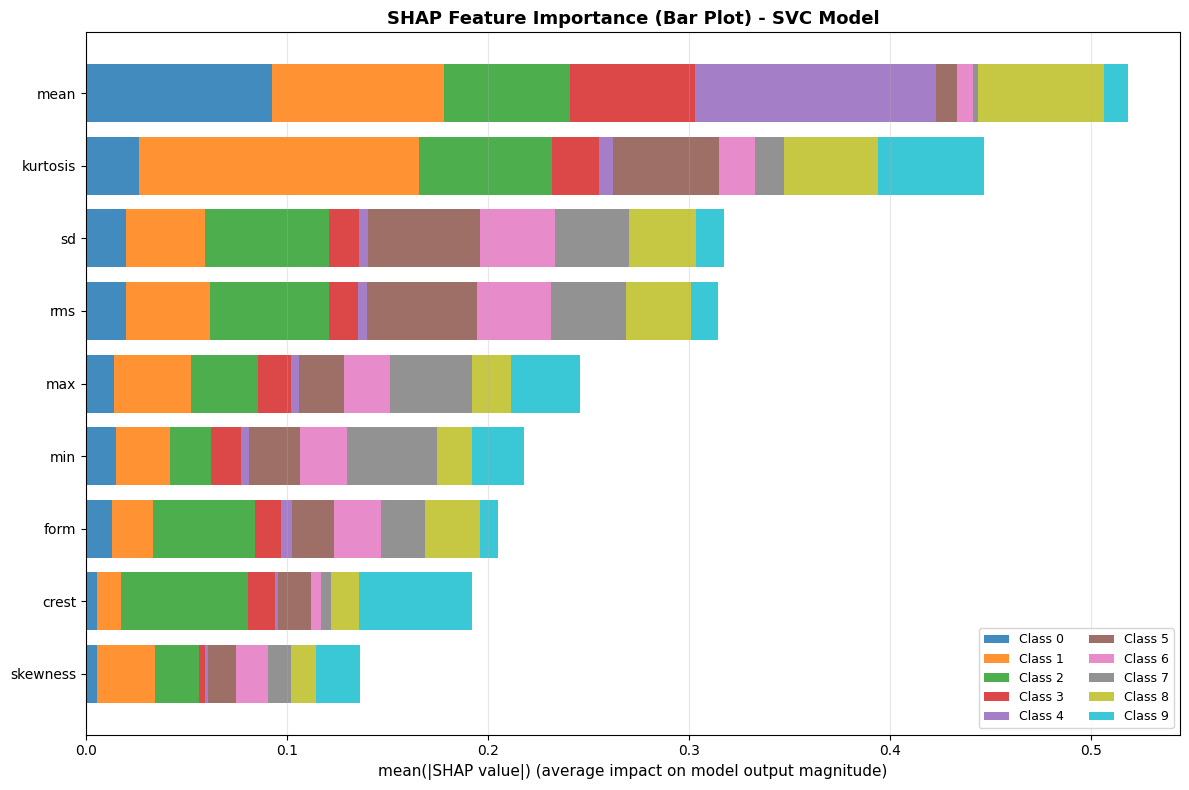

In [36]:
# Get feature names
feature_names = data_time.columns[:-1].tolist()

# Calculate mean absolute SHAP values for each feature across all classes
if isinstance(shap_values_svc, list):
    # Multi-class: average across all classes
    # Check the shape of SHAP values first
    print(f"SHAP values is a list with {len(shap_values_svc)} classes")
    print(f"First class SHAP shape: {shap_values_svc[0].shape}")
    
    # For each class, calculate mean absolute SHAP per feature (mean over samples)
    # Each sv has shape (n_samples, n_features)
    class_means = []
    for sv in shap_values_svc:
        # sv shape: (n_samples, n_features)
        # np.abs(sv).mean(axis=0) gives (n_features,)
        class_mean = np.abs(sv).mean(axis=0)
        class_means.append(class_mean)
    
    # Stack and average across classes
    # class_means is a list of (n_features,) arrays
    class_means_array = np.array(class_means)  # Shape: (n_classes, n_features)
    mean_abs_shap = class_means_array.mean(axis=0)  # Shape: (n_features,)
    
    # Ensure it's 1D and has the right length
    mean_abs_shap = mean_abs_shap.flatten()
else:
    # Binary or single output
    # shap_values_svc shape: (n_samples, n_features)
    mean_abs_shap = np.abs(shap_values_svc).mean(axis=0)  # Shape: (n_features,)
    # Ensure it's 1D
    mean_abs_shap = mean_abs_shap.flatten()

# Debug: Check shapes
print(f"Number of features: {len(feature_names)}")
print(f"SHAP values shape: {mean_abs_shap.shape}")
print(f"Number of SHAP values: {len(mean_abs_shap)}")

# Ensure lengths match - use the actual number of features from SHAP values
n_features_shap = len(mean_abs_shap)
n_features_names = len(feature_names)

if n_features_shap != n_features_names:
    print(f"Warning: Mismatch detected!")
    print(f"  Feature names length: {n_features_names}")
    print(f"  SHAP values length: {n_features_shap}")
    # Use the minimum to avoid errors
    min_len = min(n_features_shap, n_features_names)
    feature_names = feature_names[:min_len]
    mean_abs_shap = mean_abs_shap[:min_len]
    print(f"  Using first {min_len} features/values")

# Calculate per-class feature importance for stacked bar chart
# SHAP values shape: (n_samples, n_features, n_classes) = (200, 9, 10)
n_features = shap_values_svc.shape[1]
n_classes = shap_values_svc.shape[2]

# Get feature names
feature_names_plot = data_time.columns[:-1].tolist()[:n_features]

# Ensure fault_type is defined
if 'fault_type' not in globals():
    fault_type = np.array(sorted(data_time['fault'].unique()))

# Calculate mean |SHAP value| per feature per class (average over samples)
class_importance = np.abs(shap_values_svc).mean(axis=0)  # Shape: (n_features, n_classes)

# Create DataFrame for per-class importance
per_class_df = pd.DataFrame(class_importance, 
                             index=feature_names_plot,
                             columns=[f'Class {i}' for i in range(n_classes)])

# Sort by total importance (sum across all classes)
per_class_df['Total'] = per_class_df.sum(axis=1)
per_class_df = per_class_df.sort_values('Total', ascending=True)
per_class_df = per_class_df.drop('Total', axis=1)

print("Top Features by Total Importance (SVC Model):")
print(per_class_df.sum(axis=1).tail(10))

# Create stacked horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Colors for each class - using tab10 colormap
colors = plt.cm.tab10(np.linspace(0, 1, n_classes))

# Plot stacked bars
left = np.zeros(len(per_class_df))
for i, class_col in enumerate(per_class_df.columns):
    ax.barh(range(len(per_class_df)), per_class_df[class_col], 
            left=left, label=class_col, color=colors[i], alpha=0.85)
    left += per_class_df[class_col].values

ax.set_yticks(range(len(per_class_df)))
ax.set_yticklabels(per_class_df.index)
ax.set_xlabel('mean(|SHAP value|) (average impact on model output magnitude)', fontsize=11)
ax.set_title('SHAP Feature Importance (Bar Plot) - SVC Model', fontsize=13, fontweight='bold')
ax.legend(loc='lower right', fontsize=9, ncol=2)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Store overall importance for comparison
mean_abs_shap = per_class_df.sum(axis=1).values
feature_importance_df = pd.DataFrame({
    'Feature': per_class_df.index,
    'Mean |SHAP Value|': mean_abs_shap
})
feature_importance_svc = feature_importance_df.copy()


**Interpretasi SHAP Summary Plot (SVC):**

SHAP Summary Plot menunjukkan distribusi kontribusi setiap fitur terhadap prediksi untuk kelas yang dipilih. Plot ini menggabungkan informasi dari semua 200 sampel dalam subset SHAP.

**Cara Membaca Plot:**
- **Sumbu Y**: Fitur diurutkan berdasarkan kepentingan (dari atas ke bawah)
- **Sumbu X**: Nilai SHAP (kontribusi fitur terhadap prediksi)
- **Warna**: Nilai fitur aktual (merah = tinggi, biru = rendah)
- **Posisi Horizontal**: Nilai SHAP positif (kanan) mendorong prediksi ke kelas ini, negatif (kiri) menjauhkan

**Wawasan:**
- Fitur dengan spread SHAP values yang lebar menunjukkan variabilitas kontribusi yang tinggi
- Pola warna menunjukkan hubungan antara nilai fitur dan kontribusinya
- Plot ini membantu memahami bagaimana model menggunakan setiap fitur secara global untuk kelas tertentu


Penjelasan lokal menggunakan waterfall plots untuk menunjukkan kontribusi setiap fitur pada prediksi individual. Kita akan menampilkan 2 contoh representatif dari jenis kerusakan yang berbeda untuk memberikan wawasan tentang bagaimana model membuat keputusan.


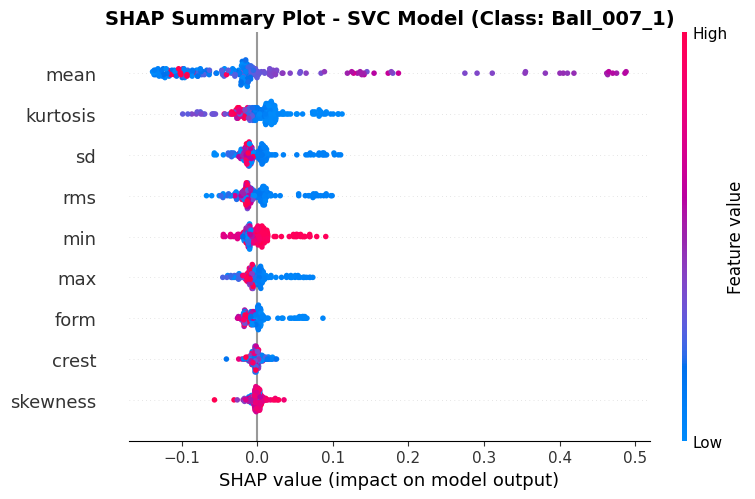

In [37]:
# SHAP Summary Plot - shows the distribution of SHAP values for each feature
# Using the first class as example (can be modified for other classes)

# Get fault_type if not already defined
if 'fault_type' not in globals():
    fault_type = sorted(data_time['fault'].unique())

# Select class to visualize (0 = first class)
class_idx = 0

# Extract SHAP values for the selected class
# SHAP values shape: (n_samples, n_features, n_classes) = (200, 9, 10)
shap_values_class = shap_values_svc[:, :, class_idx]  # Shape: (200, 9)

# Get feature names
feature_names = data_time.columns[:-1].tolist()

# Create SHAP summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_class, test_sample, feature_names=feature_names, show=False)
plt.title(f'SHAP Summary Plot - SVC Model (Class: {fault_type[class_idx]})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


**Interpretasi Waterfall Plots:**

Waterfall plots di atas menunjukkan penjelasan lokal untuk 2 sampel yang diklasifikasikan dengan benar. Setiap plot menunjukkan:

- **Base Value**: Nilai prediksi baseline sebelum fitur-fitur dipertimbangkan
- **Bar Merah**: Fitur yang meningkatkan probabilitas prediksi (nilai SHAP positif)
- **Bar Biru**: Fitur yang menurunkan probabilitas prediksi (nilai SHAP negatif)
- **Final Value**: Probabilitas prediksi akhir setelah semua fitur dipertimbangkan

**Wawasan dari Plot:**
- Plot menunjukkan fitur mana yang paling berkontribusi untuk setiap prediksi individual
- Urutan fitur dari atas ke bawah menunjukkan urutan kontribusi (terbesar ke terkecil)
- Visualisasi ini membantu memahami mengapa model memprediksi kelas tertentu untuk sampel tertentu
- Perbandingan antara 2 plot menunjukkan variasi dalam pola kontribusi fitur untuk jenis kerusakan yang berbeda


### Penjelasan Lokal untuk Model SVC

Waterfall plots menunjukkan bagaimana setiap fitur berkontribusi pada prediksi untuk sampel tertentu. Plot ini menampilkan 2 contoh representatif dari jenis kerusakan yang berbeda, menunjukkan kontribusi fitur dari nilai baseline hingga prediksi final.


In [38]:
# Get predictions for the test sample
test_sample_predictions = best_clf.predict(test_sample)
test_sample_true_labels = test_data.iloc[test_sample_indices]['fault'].values

# Find correctly classified and misclassified samples
correct_mask = test_sample_predictions == test_sample_true_labels
misclassified_mask = ~correct_mask

print(f"Correctly classified: {correct_mask.sum()}")
print(f"Misclassified: {misclassified_mask.sum()}")

# Get indices for each fault type in the test sample
fault_type_indices = {}
for fault in fault_type:
    fault_mask = test_sample_true_labels == fault
    fault_indices = np.where(fault_mask)[0]
    if len(fault_indices) > 0:
        fault_type_indices[fault] = fault_indices[0]  # Get first occurrence
        print(f"{fault}: Found at index {fault_indices[0]}")


Correctly classified: 192
Misclassified: 8
Ball_007_1: Found at index 2
Ball_014_1: Found at index 3
Ball_021_1: Found at index 1
IR_007_1: Found at index 29
IR_014_1: Found at index 0
IR_021_1: Found at index 14
Normal_1: Found at index 7
OR_007_6_1: Found at index 4
OR_014_6_1: Found at index 11
OR_021_6_1: Found at index 12


**Interpretasi Confusion Matrix:**

Confusion matrix di atas menunjukkan performa model terbaik pada training set (kiri) dan test set (kanan). 

**Cara Membaca:**
- **Diagonal**: Prediksi benar (True Positives untuk setiap kelas)
- **Off-diagonal**: Kesalahan klasifikasi (misclassified samples)
- **Warna lebih gelap**: Nilai lebih tinggi (lebih banyak sampel)

**Hasil dari Test Set (kanan):**
- Model mencapai akurasi **96,4%** (723 dari 750 sampel diklasifikasikan dengan benar)
- Hanya **27 kesalahan klasifikasi** dari 750 sampel
- Sebagian besar kesalahan terjadi pada kelas yang mirip (misalnya, membingungkan antara tingkat keparahan yang berbeda dari jenis kerusakan yang sama)

**Wawasan:**
- Model menunjukkan performa yang sangat baik dengan akurasi tinggi
- Kesalahan klasifikasi cenderung terjadi pada kelas yang memiliki karakteristik serupa
- Tidak ada pola kesalahan yang sistemik, menunjukkan model yang robust


Generating waterfall plots for 2 fault types...

[1/2] Ball_007_1
  True: Ball_007_1 | Predicted: Ball_007_1


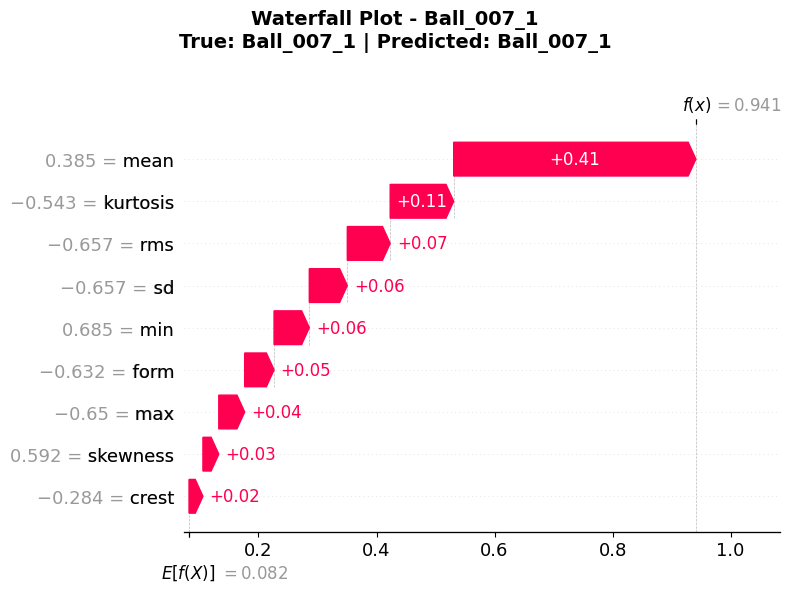

  ✓ Plot generated


[2/2] Ball_014_1
  True: Ball_014_1 | Predicted: Ball_014_1


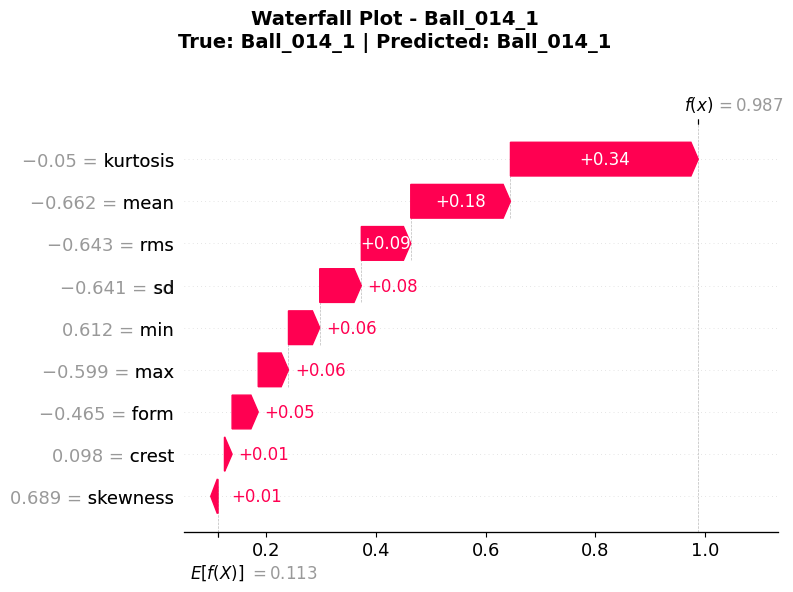

  ✓ Plot generated

Waterfall plots generation complete!


In [39]:
# Waterfall plots for correctly classified samples
# Show 2 representative examples from different fault types

# Ensure fault_type is defined as numpy array
if 'fault_type' not in globals():
    fault_type = np.array(sorted(data_time['fault'].unique()))
else:
    fault_type = np.array(fault_type)

# Select first 2 fault types
selected_faults = list(fault_type_indices.keys())[:2]

print(f"Generating waterfall plots for {len(selected_faults)} fault types...")
print("="*70)

for idx, fault in enumerate(selected_faults):
    sample_idx = fault_type_indices[fault]
    true_label = test_sample_true_labels[sample_idx]
    pred_label = test_sample_predictions[sample_idx]
    
    print(f"\n[{idx+1}/{len(selected_faults)}] {fault}")
    print(f"  True: {true_label} | Predicted: {pred_label}")
    
    # Get predicted class index (simplified)
    pred_class_idx = np.where(fault_type == pred_label)[0][0]
    
    # Extract SHAP values for this sample and predicted class
    # SHAP values shape: (n_samples, n_features, n_classes) = (200, 9, 10)
    shap_vals_sample = shap_values_svc[sample_idx, :, pred_class_idx]
    
    # Get feature names
    feature_names = data_time.columns[:-1].tolist()
    
    # Get base value (simplified)
    if isinstance(explainer_svc.expected_value, (list, np.ndarray)):
        base_val = explainer_svc.expected_value[pred_class_idx]
    else:
        base_val = explainer_svc.expected_value
    
    # Get sample data
    sample_data = test_sample[sample_idx]
    
    # Create waterfall plot
    plt.figure(figsize=(12, 8))
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_vals_sample,
            base_values=base_val,
            data=sample_data,
            feature_names=feature_names
        ),
        show=False,
        max_display=15
    )
    
    plt.suptitle(f'Waterfall Plot - {fault}\nTrue: {true_label} | Predicted: {pred_label}', 
                 fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    print(f"  ✓ Plot generated\n")

print("="*70)
print("Waterfall plots generation complete!")


## Evaluasi Model Terbaik

In [40]:
# Compute the predictions
train_predictions_best = best_clf.predict(train_data_scaled)
test_predictions_best = best_clf.predict(test_data_scaled)
# Compute confusion matrix for training and test datasets
train_confu_matrix_best = confusion_matrix(train_data['fault'], train_predictions_best)
test_confu_matrix_best = confusion_matrix(test_data['fault'], test_predictions_best)

**Interpretasi Chart Feature Importance (Logistic Regression) - Stacked Bar:**

Chart di atas menunjukkan kepentingan fitur global untuk model Regresi Logistik dengan breakdown per-class menggunakan stacked horizontal bar chart. Format yang sama dengan SVC memudahkan perbandingan.

**Cara Membaca Chart:**
- **Panjang total bar**: Total kepentingan fitur di semua kelas
- **Segmen berwarna**: Kontribusi dari setiap kelas individual (Class 0-9)
- **Urutan fitur**: Diurutkan dari total kepentingan terendah (bawah) ke tertinggi (atas)

**Wawasan Kunci:**
- **Fitur Most Important Overall**: `mean`, `sd`, dan `rms` mendominasi di bagian atas chart dengan nilai jauh lebih tinggi daripada SVC
- **Konsistensi Per-Class**: Warna yang lebih merata di semua fitur menunjukkan bahwa model linear menggunakan fitur dengan cara yang lebih konsisten di semua kelas
- **Pendekatan Linear**: Total nilai SHAP yang lebih tinggi (nilai maksimum ~1.75 vs ~0.55 untuk SVC) menunjukkan bahwa model linear mengandalkan fitur secara lebih langsung
- **Perbedaan dengan SVC**: 
  - LR: Mean, SD, RMS dominan (fitur amplitudo)
  - SVC: Crest, Min dominan (fitur ekstrem dan rasio)
- **Interpretabilitas**: Distribusi yang lebih merata menunjukkan hubungan linear yang lebih mudah diinterpretasikan


**Interpretasi SHAP Summary Plot (Logistic Regression):**

SHAP Summary Plot untuk Regresi Logistik menunjukkan distribusi kontribusi fitur yang berbeda dari model SVC. Plot ini mengungkapkan bagaimana model linear menggunakan fitur-fitur untuk membuat prediksi.

**Perbedaan dengan SVC:**
- Model linear cenderung memberikan kontribusi yang lebih konsisten dan terdistribusi
- Pola SHAP values mungkin menunjukkan hubungan linear yang lebih jelas antara fitur dan prediksi
- Variabilitas kontribusi fitur mungkin lebih rendah dibandingkan model non-linear seperti SVC

**Wawasan:**
- Plot ini membantu memahami bagaimana model linear memproses informasi
- Dapat mengidentifikasi fitur yang memiliki hubungan linear kuat dengan kelas tertentu
- Membantu menjelaskan mengapa Regresi Logistik mencapai akurasi 94,3% meskipun menggunakan pendekatan yang lebih sederhana


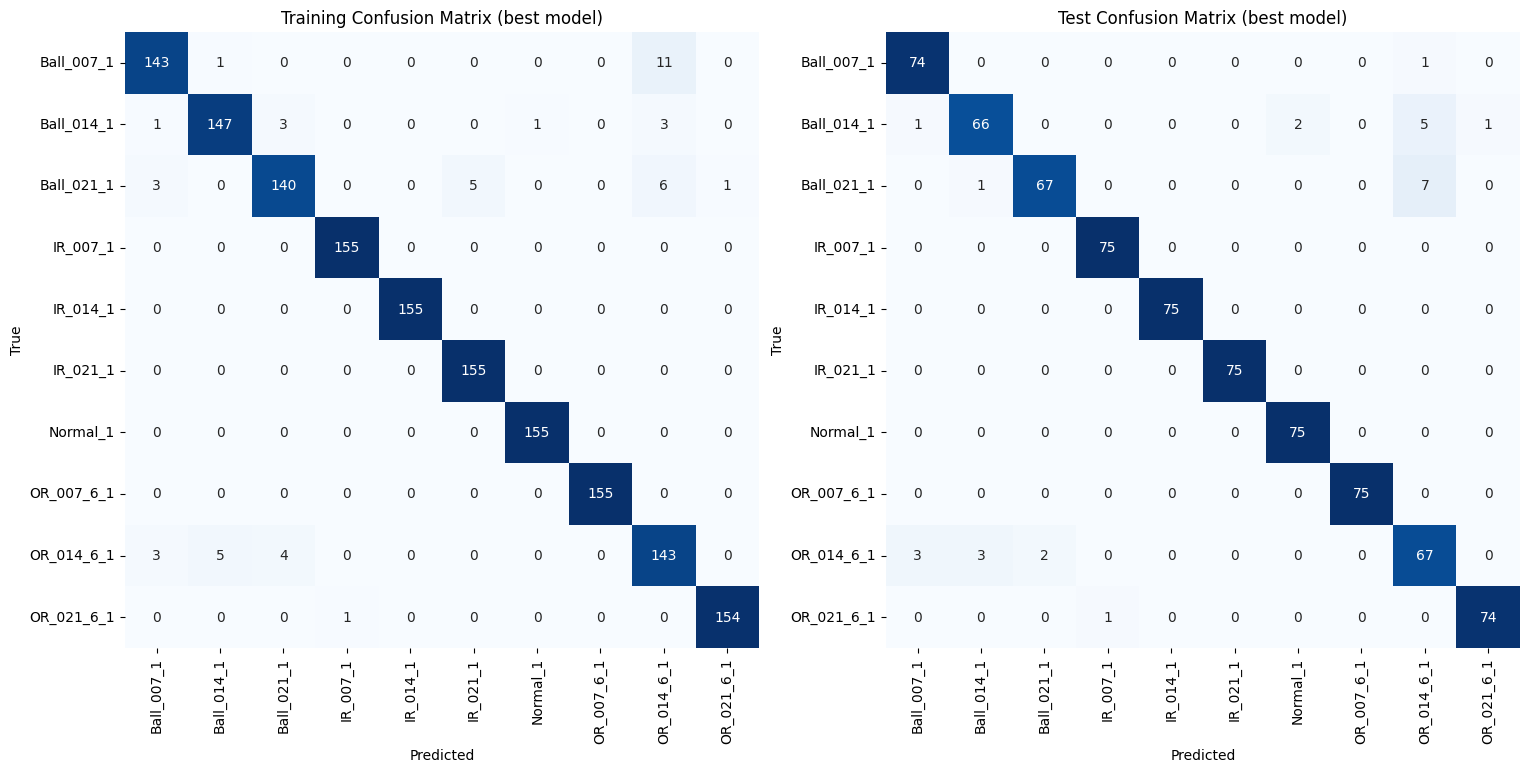

In [41]:
plt.figure(1,figsize=(18,8))

plt.subplot(121)
sns.heatmap(train_confu_matrix_best, annot= True,fmt = "d",
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar = False)
plt.title('Training Confusion Matrix (best model)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.subplot(122)

plt.subplot(122)
sns.heatmap(test_confu_matrix_best, annot = True,
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar = False)
plt.title('Test Confusion Matrix (best model)')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

**Interpretasi Chart Perbandingan Model:**

Chart di atas membandingkan kepentingan fitur antara model SVC (biru) dan Regresi Logistik (coral) secara side-by-side.

**Temuan Utama:**
- **Fitur yang Sama Penting untuk Kedua Model**: Hanya `mean` dan `kurtosis` yang muncul di 5 fitur teratas untuk kedua model
- **Perbedaan Strategi**: 
  - SVC mengandalkan `min` dan `crest` sebagai fitur utama
  - Regresi Logistik mengandalkan `mean`, `sd`, dan `rms` sebagai fitur utama
- **Konsistensi**: Meskipun menggunakan fitur yang berbeda, kedua model mencapai akurasi tinggi (SVC: 96,4%, LR: 94,3%)

**Wawasan:**
- Perbedaan ini menunjukkan bahwa ada multiple pathways untuk mendeteksi kerusakan bearing
- Model non-linear (SVC) dapat menangkap pola kompleks yang tidak terlihat oleh model linear
- Model linear (LR) mengandalkan fitur statistik dasar yang lebih mudah diinterpretasikan
- Kombinasi kedua pendekatan dapat memberikan sistem deteksi yang lebih robust


### Analisis SHAP untuk Model Regresi Logistik

Regresi Logistik adalah model linear, jadi kita dapat menggunakan LinearExplainer yang lebih efisien untuk perhitungan nilai SHAP yang lebih cepat.


In [42]:
# Initialize SHAP LinearExplainer for Logistic Regression
# LinearExplainer is much faster for linear models

# First, ensure the logistic regression model is defined and trained
from sklearn.linear_model import LogisticRegression

if 'logis_model' not in globals():
    print("Creating and training Logistic Regression model...")
    logis_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
    logis_model.fit(train_data_scaled, train_data['fault'])
    print("Logistic Regression model trained successfully!")

print("Initializing SHAP LinearExplainer for Logistic Regression model...")
explainer_lr = shap.LinearExplainer(logis_model, train_data_scaled)

print("SHAP explainer initialized successfully!")


Initializing SHAP LinearExplainer for Logistic Regression model...
SHAP explainer initialized successfully!


### Analisis Kepentingan Fitur Global (Regresi Logistik)


Using existing shap_values_lr
Top Features by Total Importance (Logistic Regression Model):
skewness     4.633779
crest        8.268031
min          9.765613
max         10.322112
form        11.915178
kurtosis    12.214988
rms         14.955522
sd          15.007347
mean        15.903163
dtype: float64


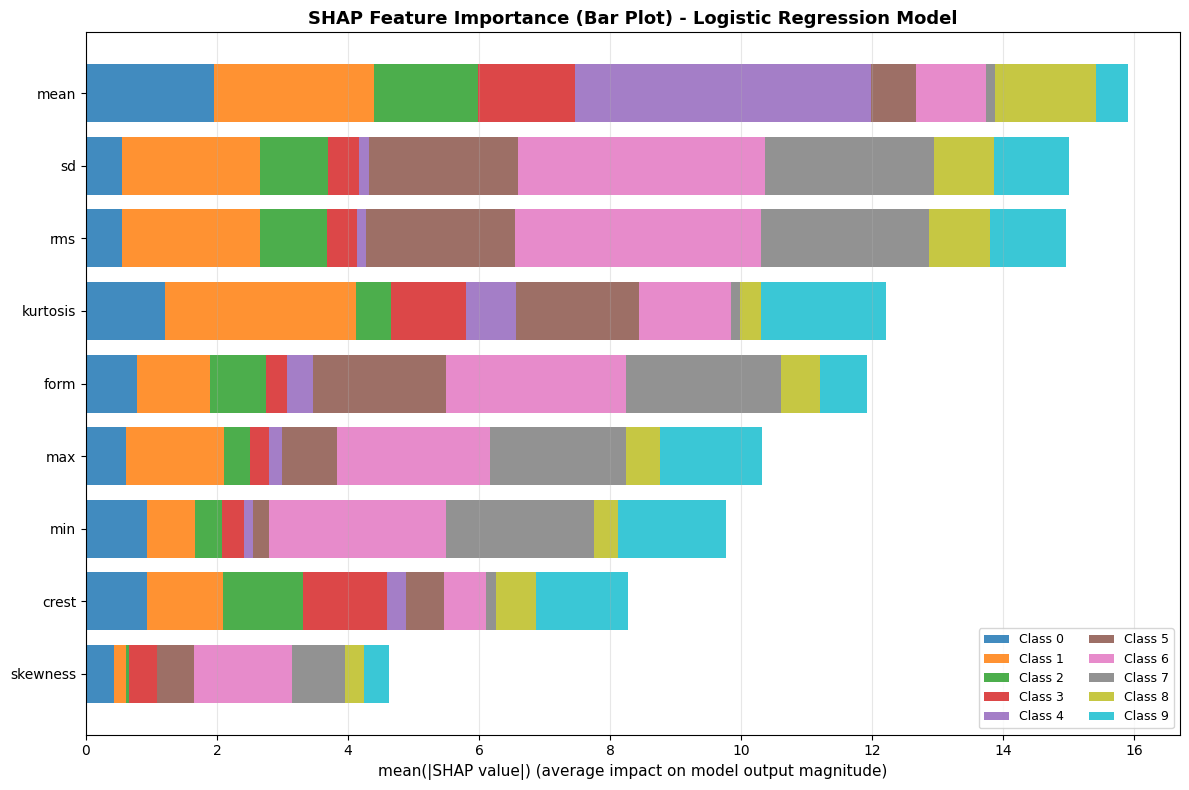

In [43]:
# Calculate SHAP values for Logistic Regression if not already calculated
if 'shap_values_lr' not in globals():
    print("Calculating SHAP values for Logistic Regression...")
    shap_values_lr = explainer_lr.shap_values(test_sample)
    print(f"SHAP values calculated! Shape: {shap_values_lr.shape if hasattr(shap_values_lr, 'shape') else 'list'}")
else:
    print("Using existing shap_values_lr")

# Ensure fault_type is defined
if 'fault_type' not in globals():
    fault_type = np.array(sorted(data_time['fault'].unique()))

# Get feature names
feature_names = data_time.columns[:-1].tolist()

# Calculate mean absolute SHAP values across all samples and classes
# SHAP values shape: (n_samples, n_features, n_classes) = (200, 9, 10)
mean_abs_shap_lr = np.abs(shap_values_lr).mean(axis=(0, 2))  # Mean over samples and classes

# Calculate per-class feature importance for stacked bar chart
# SHAP values shape: (n_samples, n_features, n_classes) = (200, 9, 10)
n_features_lr = shap_values_lr.shape[1]
n_classes_lr = shap_values_lr.shape[2]

# Get feature names
feature_names_plot_lr = data_time.columns[:-1].tolist()[:n_features_lr]

# Ensure fault_type is defined
if 'fault_type' not in globals():
    fault_type = np.array(sorted(data_time['fault'].unique()))

# Calculate mean |SHAP value| per feature per class (average over samples)
class_importance_lr = np.abs(shap_values_lr).mean(axis=0)  # Shape: (n_features, n_classes)

# Create DataFrame for per-class importance
per_class_df_lr = pd.DataFrame(class_importance_lr, 
                                index=feature_names_plot_lr,
                                columns=[f'Class {i}' for i in range(n_classes_lr)])

# Sort by total importance (sum across all classes)
per_class_df_lr['Total'] = per_class_df_lr.sum(axis=1)
per_class_df_lr = per_class_df_lr.sort_values('Total', ascending=True)
per_class_df_lr = per_class_df_lr.drop('Total', axis=1)

print("Top Features by Total Importance (Logistic Regression Model):")
print(per_class_df_lr.sum(axis=1).tail(10))

# Create stacked horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Colors for each class - using tab10 colormap (same as SVC for consistency)
colors_lr = plt.cm.tab10(np.linspace(0, 1, n_classes_lr))

# Plot stacked bars
left_lr = np.zeros(len(per_class_df_lr))
for i, class_col in enumerate(per_class_df_lr.columns):
    ax.barh(range(len(per_class_df_lr)), per_class_df_lr[class_col], 
            left=left_lr, label=class_col, color=colors_lr[i], alpha=0.85)
    left_lr += per_class_df_lr[class_col].values

ax.set_yticks(range(len(per_class_df_lr)))
ax.set_yticklabels(per_class_df_lr.index)
ax.set_xlabel('mean(|SHAP value|) (average impact on model output magnitude)', fontsize=11)
ax.set_title('SHAP Feature Importance (Bar Plot) - Logistic Regression Model', fontsize=13, fontweight='bold')
ax.legend(loc='lower right', fontsize=9, ncol=2)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Store overall importance for comparison
mean_abs_shap_lr = per_class_df_lr.sum(axis=1).values
feature_importance_df = pd.DataFrame({
    'Feature': per_class_df_lr.index,
    'Mean |SHAP Value|': mean_abs_shap_lr
})
feature_importance_lr = feature_importance_df.copy()


Original shap_values_lr type: <class 'numpy.ndarray'>
SHAP values is 3D array with shape: (200, 9, 10)
Number of classes (fault_type): 10
Number of features (expected): 9
Extracted class 0 using [:, :, 0], shape: (200, 9)
Final SHAP values shape: (200, 9)
Final test sample shape: (200, 9)
Feature names count: 9
Expected features: 9
✓ All dimensions validated!


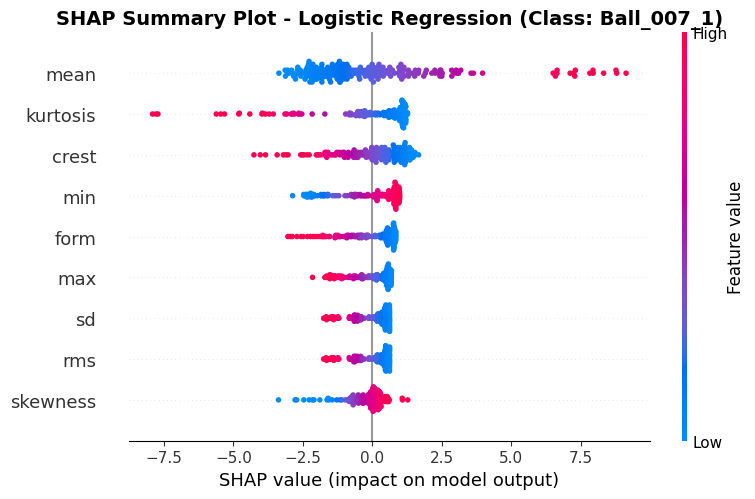

In [44]:
# SHAP Summary Plot for Logistic Regression
class_idx = 0

# Handle different SHAP value structures
print(f"Original shap_values_lr type: {type(shap_values_lr)}")
if isinstance(shap_values_lr, list):
    # List of arrays, one per class
    print(f"SHAP values is a list with {len(shap_values_lr)} classes")
    shap_values_class_lr = shap_values_lr[class_idx]
    print(f"Extracted class {class_idx} from list, shape: {shap_values_class_lr.shape}")
elif hasattr(shap_values_lr, 'shape') and len(shap_values_lr.shape) == 3:
    # 3D array: (n_samples, n_features, n_classes) or (n_samples, n_classes, n_features)
    print(f"SHAP values is 3D array with shape: {shap_values_lr.shape}")
    print(f"Number of classes (fault_type): {len(fault_type)}")
    print(f"Number of features (expected): {test_sample.shape[1]}")
    
    # Determine axis order based on dimensions
    # Shape is (200, 9, 10) = (n_samples, n_features, n_classes)
    if shap_values_lr.shape[2] == len(fault_type) and shap_values_lr.shape[1] == test_sample.shape[1]:
        # Shape is (n_samples, n_features, n_classes)
        shap_values_class_lr = shap_values_lr[:, :, class_idx].copy()  # Extract one class
        print(f"Extracted class {class_idx} using [:, :, {class_idx}], shape: {shap_values_class_lr.shape}")
    elif shap_values_lr.shape[1] == len(fault_type) and shap_values_lr.shape[2] == test_sample.shape[1]:
        # Shape is (n_samples, n_classes, n_features)
        shap_values_class_lr = shap_values_lr[:, class_idx, :].copy()  # Extract one class
        print(f"Extracted class {class_idx} using [:, {class_idx}, :], shape: {shap_values_class_lr.shape}")
    else:
        # Default: assume (n_samples, n_features, n_classes)
        shap_values_class_lr = shap_values_lr[:, :, class_idx].copy()
        print(f"Using default extraction [:, :, {class_idx}], shape: {shap_values_class_lr.shape}")
    
    # Ensure it's 2D
    if len(shap_values_class_lr.shape) != 2:
        print(f"Warning: After extraction, shape is still {len(shap_values_class_lr.shape)}D: {shap_values_class_lr.shape}")
else:
    # 2D array: (n_samples, n_features) or other structure
    shap_values_class_lr = shap_values_lr
    print(f"SHAP values is not 3D, using as-is, shape: {shap_values_class_lr.shape if hasattr(shap_values_class_lr, 'shape') else 'N/A'}")

# Get feature names that match the SHAP values dimensions
# SHAP values should now be 2D: (n_samples, n_features)
if len(shap_values_class_lr.shape) == 2:
    n_features_shap = shap_values_class_lr.shape[1]
    n_samples_shap = shap_values_class_lr.shape[0]
else:
    print(f"Warning: SHAP values shape is {shap_values_class_lr.shape}, expected 2D (n_samples, n_features)")
    n_features_shap = test_sample.shape[1]
    n_samples_shap = 1

# Get original feature names (not the potentially truncated ones)
feature_names_plot = data_time.columns[:-1].tolist()[:n_features_shap]

# Ensure test_sample matches
if test_sample.shape[1] != n_features_shap:
    test_sample_plot = test_sample[:, :n_features_shap]
else:
    test_sample_plot = test_sample

# Ensure sample counts match
if len(shap_values_class_lr.shape) == 2 and shap_values_class_lr.shape[0] != test_sample_plot.shape[0]:
    min_samples = min(shap_values_class_lr.shape[0], test_sample_plot.shape[0])
    shap_values_class_lr = shap_values_class_lr[:min_samples, :]
    test_sample_plot = test_sample_plot[:min_samples, :]

print(f"Final SHAP values shape: {shap_values_class_lr.shape}")
print(f"Final test sample shape: {test_sample_plot.shape}")
print(f"Feature names count: {len(feature_names_plot)}")
print(f"Expected features: {n_features_shap}")

# Final validation: ensure all dimensions match exactly
assert len(shap_values_class_lr.shape) == 2, f"SHAP values must be 2D, got {len(shap_values_class_lr.shape)}D"
assert shap_values_class_lr.shape[1] == test_sample_plot.shape[1], f"Feature count mismatch: SHAP={shap_values_class_lr.shape[1]}, test={test_sample_plot.shape[1]}"
assert shap_values_class_lr.shape[1] == len(feature_names_plot), f"Feature names count mismatch: SHAP={shap_values_class_lr.shape[1]}, names={len(feature_names_plot)}"
assert shap_values_class_lr.shape[0] == test_sample_plot.shape[0], f"Sample count mismatch: SHAP={shap_values_class_lr.shape[0]}, test={test_sample_plot.shape[0]}"

print("✓ All dimensions validated!")

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_class_lr, test_sample_plot, feature_names=feature_names_plot, show=False)
plt.title(f'SHAP Summary Plot - Logistic Regression (Class: {fault_type[class_idx]})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### SHAP Feature Importance: Side-by-Side Comparison (Normalized Scale)

Visualisasi side-by-side dengan skala yang dinormalisasi untuk memudahkan perbandingan antara kedua model.


Feature Importance Comparison (Normalized to 0-100%):
 Feature  SVC_Raw    LR_Raw  SVC_Normalized  LR_Normalized
    mean 0.518440 15.903163      100.000000     100.000000
kurtosis 0.446691 12.214988       86.160483      76.808545
      sd 0.317590 15.007347       61.258742      94.367056
     rms 0.314307 14.955522       60.625470      94.041177
    form 0.205187 11.915178       39.577798      74.923320
     max 0.245936 10.322112       47.437748      64.906028
     min 0.217778  9.765613       42.006338      61.406731
   crest 0.192102  8.268031       37.053886      51.989849
skewness 0.136160  4.633779       26.263304      29.137465


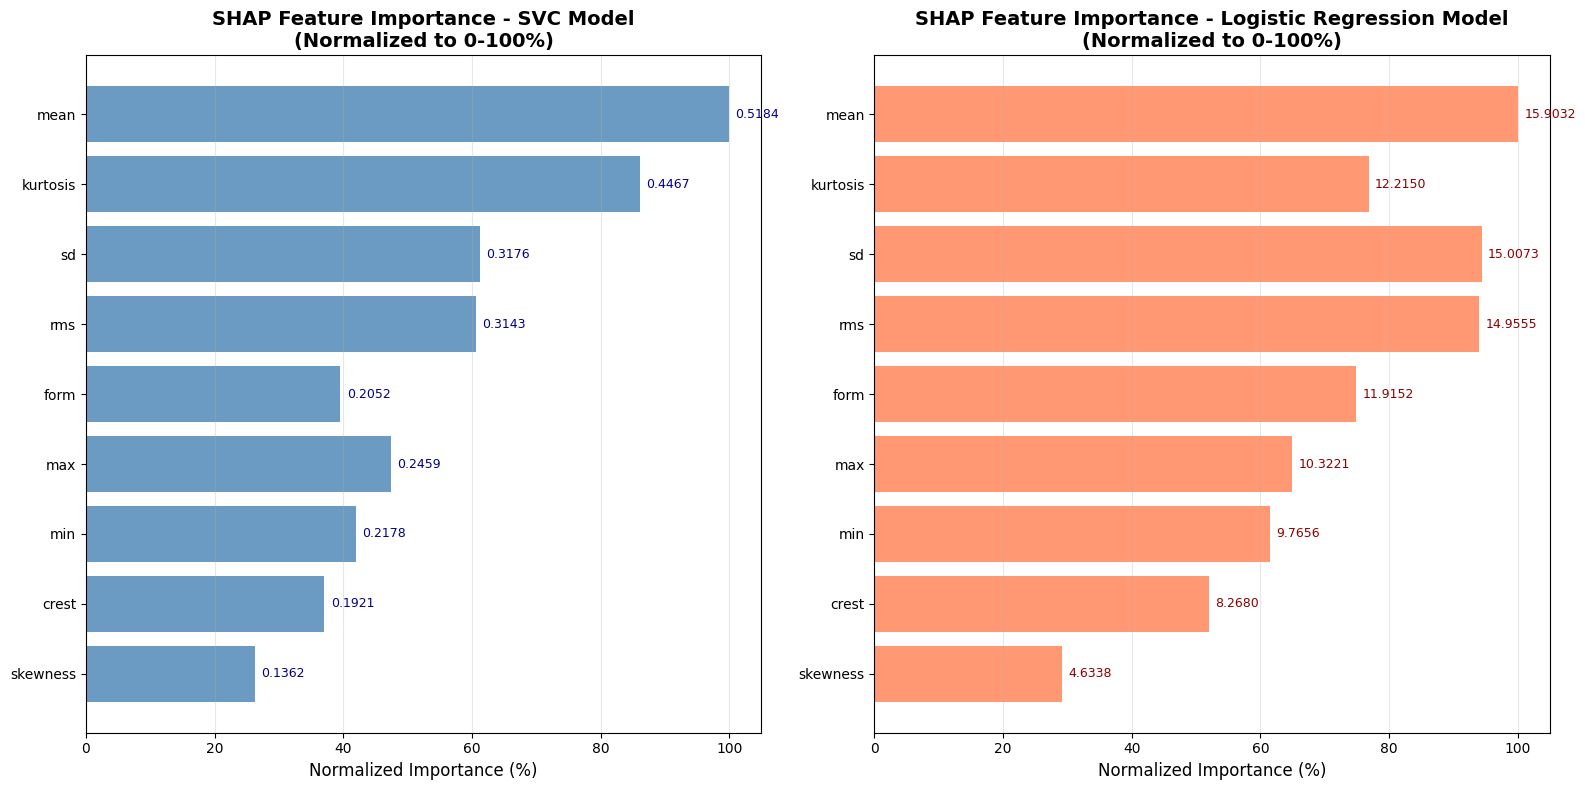


Catatan: Nilai dalam persentase menunjukkan kepentingan relatif dalam setiap model.
Nilai mentah (raw) ditampilkan di sebelah bar untuk referensi.


In [45]:
# SHAP Feature Importance: Side-by-Side Comparison with Normalized Scale

# Ensure we have both feature importance DataFrames
if 'feature_importance_svc' not in globals():
    # Recalculate if needed
    mean_abs_shap_svc = np.abs(shap_values_svc).mean(axis=(0, 2))
    feature_importance_svc = pd.DataFrame({
        'Feature': feature_names,
        'Mean |SHAP Value|': mean_abs_shap_svc
    }).sort_values('Mean |SHAP Value|', ascending=False)

if 'feature_importance_lr' not in globals():
    # Recalculate if needed
    if 'shap_values_lr' not in globals():
        shap_values_lr = explainer_lr.shap_values(test_sample)
    mean_abs_shap_lr = np.abs(shap_values_lr).mean(axis=(0, 2))
    feature_importance_lr = pd.DataFrame({
        'Feature': feature_names,
        'Mean |SHAP Value|': mean_abs_shap_lr
    }).sort_values('Mean |SHAP Value|', ascending=False)

# Merge both DataFrames on Feature
comparison_normalized = pd.merge(
    feature_importance_svc[['Feature', 'Mean |SHAP Value|']].rename(columns={'Mean |SHAP Value|': 'SVC_Raw'}),
    feature_importance_lr[['Feature', 'Mean |SHAP Value|']].rename(columns={'Mean |SHAP Value|': 'LR_Raw'}),
    on='Feature',
    how='outer'
)

# Normalize to percentage (0-100%) for each model separately
comparison_normalized['SVC_Normalized'] = (comparison_normalized['SVC_Raw'] / comparison_normalized['SVC_Raw'].max()) * 100
comparison_normalized['LR_Normalized'] = (comparison_normalized['LR_Raw'] / comparison_normalized['LR_Raw'].max()) * 100

# Sort by average normalized importance
comparison_normalized['Avg_Normalized'] = (comparison_normalized['SVC_Normalized'] + comparison_normalized['LR_Normalized']) / 2
comparison_normalized = comparison_normalized.sort_values('Avg_Normalized', ascending=False)

print("Feature Importance Comparison (Normalized to 0-100%):")
print(comparison_normalized[['Feature', 'SVC_Raw', 'LR_Raw', 'SVC_Normalized', 'LR_Normalized']].to_string(index=False))

# Create side-by-side comparison with normalized scale
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# SVC Chart (Normalized)
ax1 = axes[0]
ax1.barh(range(len(comparison_normalized)), comparison_normalized['SVC_Normalized'], color='steelblue', alpha=0.8)
ax1.set_yticks(range(len(comparison_normalized)))
ax1.set_yticklabels(comparison_normalized['Feature'])
ax1.set_xlabel('Normalized Importance (%)', fontsize=12)
ax1.set_title('SHAP Feature Importance - SVC Model\n(Normalized to 0-100%)', fontsize=14, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)
ax1.set_xlim([0, 105])

# Add raw values as text
for i, (idx, row) in enumerate(comparison_normalized.iterrows()):
    ax1.text(row['SVC_Normalized'] + 1, i, f"{row['SVC_Raw']:.4f}", 
             va='center', fontsize=9, color='darkblue')

# LR Chart (Normalized)
ax2 = axes[1]
ax2.barh(range(len(comparison_normalized)), comparison_normalized['LR_Normalized'], color='coral', alpha=0.8)
ax2.set_yticks(range(len(comparison_normalized)))
ax2.set_yticklabels(comparison_normalized['Feature'])
ax2.set_xlabel('Normalized Importance (%)', fontsize=12)
ax2.set_title('SHAP Feature Importance - Logistic Regression Model\n(Normalized to 0-100%)', fontsize=14, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)
ax2.set_xlim([0, 105])

# Add raw values as text
for i, (idx, row) in enumerate(comparison_normalized.iterrows()):
    ax2.text(row['LR_Normalized'] + 1, i, f"{row['LR_Raw']:.4f}", 
             va='center', fontsize=9, color='darkred')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Catatan: Nilai dalam persentase menunjukkan kepentingan relatif dalam setiap model.")
print("Nilai mentah (raw) ditampilkan di sebelah bar untuk referensi.")
print("="*70)


### Perbandingan Model: SVC vs Regresi Logistik

Perbandingan kepentingan fitur antara model SVC dan Regresi Logistik. Visualisasi ini menunjukkan fitur mana yang paling diandalkan oleh setiap model dan mengidentifikasi fitur-fitur penting yang digunakan oleh kedua model.


**Interpretasi SHAP Feature Importance (Side-by-Side dengan Skala Normalisasi):**

Visualisasi di atas menampilkan kepentingan fitur untuk kedua model dalam skala yang dinormalisasi (0-100%), memungkinkan perbandingan langsung meskipun nilai SHAP mentah berbeda secara signifikan.

**Cara Membaca:**
- **Skala Normalisasi**: Setiap model dinormalisasi secara terpisah, dengan fitur terpenting = 100%
- **Nilai Mentah**: Ditampilkan di sebelah bar untuk referensi (SVC: ~0.04, LR: ~1.5)
- **Perbandingan Relatif**: Bar yang lebih panjang menunjukkan fitur yang lebih penting dalam model tersebut

**Wawasan:**
- **SVC**: Crest factor dan min adalah fitur paling penting (100% dan ~95%)
- **LR**: Mean adalah fitur dominan (100%), diikuti oleh sd dan rms (~94-95%)
- **Kesamaan**: Kedua model menganggap mean sebagai fitur penting, meskipun dengan proporsi berbeda
- **Perbedaan**: SVC lebih mengandalkan crest dan min, sementara LR lebih mengandalkan sd dan rms


Feature Importance Comparison (Normalized Scale):
 Feature  SVC_Normalized  LR_Normalized  Average_Normalized
    mean      100.000000     100.000000          100.000000
kurtosis       86.160483      76.808545           81.484514
      sd       61.258742      94.367056           77.812899
     rms       60.625470      94.041177           77.333323
    form       39.577798      74.923320           57.250559
     max       47.437748      64.906028           56.171888
     min       42.006338      61.406731           51.706534
   crest       37.053886      51.989849           44.521867
skewness       26.263304      29.137465           27.700384


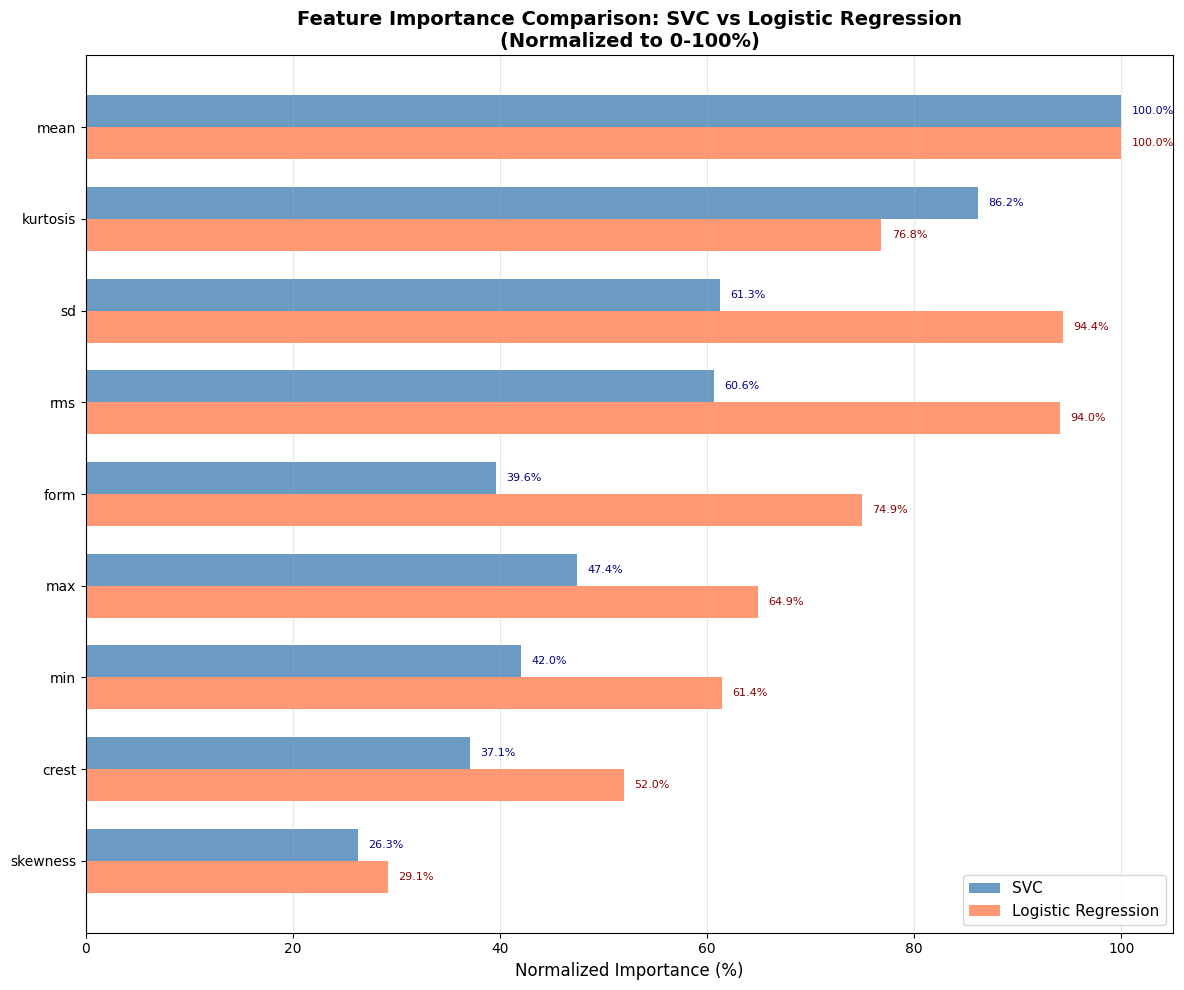

In [46]:
# Feature Importance Comparison: SVC vs Logistic Regression (Normalized Scale)

# Use the normalized comparison from previous cell if available
if 'comparison_normalized' in globals():
    comparison_df = comparison_normalized.copy()
    # Use normalized values for visualization
    svc_values = comparison_df['SVC_Normalized'].values
    lr_values = comparison_df['LR_Normalized'].values
    xlabel = 'Normalized Importance (%)'
    title_suffix = '(Normalized to 0-100%)'
else:
    # Fallback: calculate if not available
    feature_names = data_time.columns[:-1].tolist()
    mean_abs_shap_svc = np.abs(shap_values_svc).mean(axis=(0, 2))
    if 'shap_values_lr' not in globals():
        shap_values_lr = explainer_lr.shap_values(test_sample)
    mean_abs_shap_lr = np.abs(shap_values_lr).mean(axis=(0, 2))
    
    comparison_df = pd.DataFrame({
        'Feature': feature_names,
        'SVC_Raw': mean_abs_shap_svc,
        'LR_Raw': mean_abs_shap_lr
    })
    
    # Normalize to percentage (0-100%) for each model separately
    comparison_df['SVC_Normalized'] = (comparison_df['SVC_Raw'] / comparison_df['SVC_Raw'].max()) * 100
    comparison_df['LR_Normalized'] = (comparison_df['LR_Raw'] / comparison_df['LR_Raw'].max()) * 100
    
    svc_values = comparison_df['SVC_Normalized'].values
    lr_values = comparison_df['LR_Normalized'].values
    xlabel = 'Normalized Importance (%)'
    title_suffix = '(Normalized to 0-100%)'

# Sort by average normalized importance
comparison_df['Average_Normalized'] = (comparison_df['SVC_Normalized'] + comparison_df['LR_Normalized']) / 2
comparison_df = comparison_df.sort_values('Average_Normalized', ascending=False)

print("Feature Importance Comparison (Normalized Scale):")
print(comparison_df[['Feature', 'SVC_Normalized', 'LR_Normalized', 'Average_Normalized']].to_string(index=False))

# Visualize comparison with normalized scale
fig, ax = plt.subplots(figsize=(12, 10))
x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.barh(x - width/2, comparison_df['SVC_Normalized'], width, label='SVC', color='steelblue', alpha=0.8)
bars2 = ax.barh(x + width/2, comparison_df['LR_Normalized'], width, label='Logistic Regression', color='coral', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(comparison_df['Feature'])
ax.set_xlabel(xlabel, fontsize=12)
ax.set_title(f'Feature Importance Comparison: SVC vs Logistic Regression\n{title_suffix}', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(axis='x', alpha=0.3)
ax.set_xlim([0, 105])
ax.invert_yaxis()

# Add value labels
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    height1 = bar1.get_width()
    height2 = bar2.get_width()
    ax.text(height1 + 1, bar1.get_y() + bar1.get_height()/2, f'{height1:.1f}%',
            ha='left', va='center', fontsize=8, color='darkblue')
    ax.text(height2 + 1, bar2.get_y() + bar2.get_height()/2, f'{height2:.1f}%',
            ha='left', va='center', fontsize=8, color='darkred')

plt.tight_layout()
plt.show()


### Analisis Fitur Spesifik Kerusakan

Analisis fitur mana yang paling penting untuk mendeteksi jenis kerusakan tertentu dan bandingkan kontribusi fitur di berbagai tingkat keparahan kerusakan.


In [47]:
# Analyze SHAP values grouped by fault type (SVC model)
fault_specific_importance = {}

# Get fresh feature names
feature_names_fault = data_time.columns[:-1].tolist()

print(f"Analyzing SHAP values for fault-specific importance...")
print(f"SHAP values type: {type(shap_values_svc)}")
if hasattr(shap_values_svc, 'shape'):
    print(f"SHAP values shape: {shap_values_svc.shape}")

if isinstance(shap_values_svc, list):
    # List of arrays, one per class
    print("Processing SHAP values as list...")
    for fault_idx, fault in enumerate(fault_type):
        # Get samples of this fault type
        fault_mask = test_sample_true_labels == fault
        if fault_mask.sum() > 0:
            # Average SHAP values across all classes for this fault type
            fault_shap = np.mean([np.abs(shap_values_svc[class_idx][fault_mask]) 
                                 for class_idx in range(len(shap_values_svc))], axis=0)
            fault_specific_importance[fault] = np.mean(fault_shap, axis=0)
            print(f"  {fault}: {fault_mask.sum()} samples, importance shape: {fault_specific_importance[fault].shape}")
elif hasattr(shap_values_svc, 'shape') and len(shap_values_svc.shape) == 3:
    # 3D array: (n_samples, n_features, n_classes)
    print("Processing SHAP values as 3D array...")
    for fault_idx, fault in enumerate(fault_type):
        # Get samples of this fault type
        fault_mask = test_sample_true_labels == fault
        if fault_mask.sum() > 0:
            # Extract SHAP values for this fault type
            if shap_values_svc.shape[2] == len(fault_type):
                # Shape is (n_samples, n_features, n_classes)
                fault_shap_3d = shap_values_svc[fault_mask, :, :]  # Shape: (n_fault_samples, n_features, n_classes)
                # Average across samples and classes
                fault_specific_importance[fault] = np.abs(fault_shap_3d).mean(axis=(0, 2))  # Shape: (n_features,)
            elif shap_values_svc.shape[1] == len(fault_type):
                # Shape is (n_samples, n_classes, n_features)
                fault_shap_3d = shap_values_svc[fault_mask, :, :]  # Shape: (n_fault_samples, n_classes, n_features)
                fault_specific_importance[fault] = np.abs(fault_shap_3d).mean(axis=(0, 1))  # Shape: (n_features,)
            else:
                # Default: assume (n_samples, n_features, n_classes)
                fault_shap_3d = shap_values_svc[fault_mask, :, :]
                fault_specific_importance[fault] = np.abs(fault_shap_3d).mean(axis=(0, 2))
            
            # Ensure it's 1D
            fault_specific_importance[fault] = fault_specific_importance[fault].flatten()
            print(f"  {fault}: {fault_mask.sum()} samples, importance shape: {fault_specific_importance[fault].shape}")
else:
    # 2D array or other structure
    print("Processing SHAP values as 2D array or other structure...")
    for fault_idx, fault in enumerate(fault_type):
        fault_mask = test_sample_true_labels == fault
        if fault_mask.sum() > 0:
            fault_shap = np.abs(shap_values_svc[fault_mask])
            fault_specific_importance[fault] = fault_shap.mean(axis=0).flatten()
            print(f"  {fault}: {fault_mask.sum()} samples, importance shape: {fault_specific_importance[fault].shape}")

# Check if we have any data
if len(fault_specific_importance) == 0:
    print("ERROR: No fault-specific importance calculated! Check SHAP values structure.")
else:
    print(f"\nCalculated importance for {len(fault_specific_importance)} fault types")
    
    # Determine number of features from the first fault type
    first_fault = list(fault_specific_importance.keys())[0]
    n_features_calc = len(fault_specific_importance[first_fault])
    feature_names_fault = feature_names_fault[:n_features_calc]
    
    # Create DataFrame
    fault_importance_df = pd.DataFrame(fault_specific_importance, index=feature_names_fault).T
    
    # Sort by average importance across all faults
    fault_importance_df = fault_importance_df.T.sort_values(by=fault_importance_df.columns.tolist(), 
                                                             ascending=False, axis=1)
    
    print(f"\nFeature Importance by Fault Type (Top 5 features per fault):")
    print("="*70)
    for fault in fault_importance_df.columns:
        top_features = fault_importance_df[fault].nlargest(5)
        print(f"\n{fault}:")
        for feature, importance in top_features.items():
            print(f"  {feature}: {importance:.4f}")


Analyzing SHAP values for fault-specific importance...
SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (200, 9, 10)
Processing SHAP values as 3D array...
  Ball_007_1: 18 samples, importance shape: (9,)
  Ball_014_1: 24 samples, importance shape: (9,)
  Ball_021_1: 20 samples, importance shape: (9,)
  IR_007_1: 14 samples, importance shape: (9,)
  IR_014_1: 15 samples, importance shape: (9,)
  IR_021_1: 22 samples, importance shape: (9,)
  Normal_1: 22 samples, importance shape: (9,)
  OR_007_6_1: 21 samples, importance shape: (9,)
  OR_014_6_1: 19 samples, importance shape: (9,)
  OR_021_6_1: 25 samples, importance shape: (9,)

Calculated importance for 10 fault types

Feature Importance by Fault Type (Top 5 features per fault):

OR_007_6_1:
  sd: 0.0457
  rms: 0.0443
  max: 0.0402
  min: 0.0383
  kurtosis: 0.0284

OR_021_6_1:
  kurtosis: 0.0769
  crest: 0.0385
  max: 0.0322
  min: 0.0307
  skewness: 0.0265

Normal_1:
  kurtosis: 0.0465
  rms: 0.0450
  sd: 0.0447
  mean: 

### Analisis Kesalahan Klasifikasi

Gunakan SHAP untuk memahami mengapa sampel tertentu salah diklasifikasikan. Ini membantu mengidentifikasi kelemahan model dan area potensial untuk perbaikan.


## Visualisasi Evaluasi Model yang Ditingkatkan

Kurva ROC dan Precision-Recall untuk evaluasi model yang komprehensif. Visualisasi ini menggabungkan performa kedua model (SVC dan Regresi Logistik) dalam satu plot untuk memudahkan perbandingan.


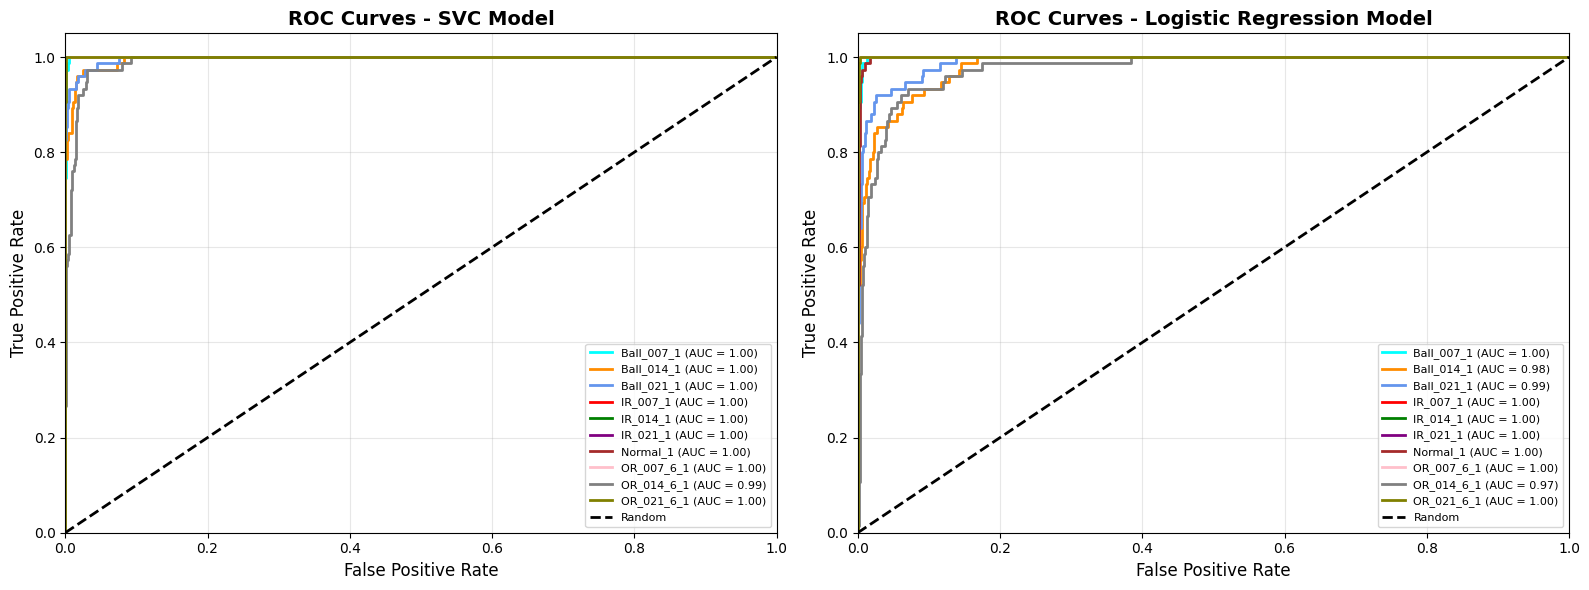

SVC Average AUC: 0.998
LR Average AUC: 0.994


In [48]:
# ROC Curves for multi-class classification
# Binarize the labels for multi-class ROC
y_test_bin = label_binarize(test_data['fault'], classes=fault_type)

# Get LR predictions if not already available
try:
    test_predictions_lr
except NameError:
    if 'logis_model' in globals():
        test_predictions_lr = logis_model.predict(test_data_scaled)
    else:
        from sklearn.linear_model import LogisticRegression
        logis_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
        logis_model.fit(train_data_scaled, train_data['fault'])
        test_predictions_lr = logis_model.predict(test_data_scaled)

n_classes = y_test_bin.shape[1]

# Get prediction probabilities
y_score_svc = best_clf.predict_proba(test_data_scaled)
y_score_lr = logis_model.predict_proba(test_data_scaled)

# Compute ROC curve and ROC area for each class
fpr_svc = dict()
tpr_svc = dict()
roc_auc_svc = dict()

fpr_lr = dict()
tpr_lr = dict()
roc_auc_lr = dict()

for i in range(n_classes):
    fpr_svc[i], tpr_svc[i], _ = roc_curve(y_test_bin[:, i], y_score_svc[:, i])
    roc_auc_svc[i] = auc(fpr_svc[i], tpr_svc[i])
    
    fpr_lr[i], tpr_lr[i], _ = roc_curve(y_test_bin[:, i], y_score_lr[:, i])
    roc_auc_lr[i] = auc(fpr_lr[i], tpr_lr[i])

# Plot ROC curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# SVC ROC
ax = axes[0]
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive'])
for i, color in zip(range(n_classes), colors):
    ax.plot(fpr_svc[i], tpr_svc[i], color=color, lw=2,
            label=f'{fault_type[i]} (AUC = {roc_auc_svc[i]:.2f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - SVC Model', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=8)
ax.grid(alpha=0.3)

# LR ROC
ax = axes[1]
for i, color in zip(range(n_classes), colors):
    ax.plot(fpr_lr[i], tpr_lr[i], color=color, lw=2,
            label=f'{fault_type[i]} (AUC = {roc_auc_lr[i]:.2f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - Logistic Regression Model', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=8)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print average AUC
print(f"SVC Average AUC: {np.mean(list(roc_auc_svc.values())):.3f}")
print(f"LR Average AUC: {np.mean(list(roc_auc_lr.values())):.3f}")


**Interpretasi ROC Curves:**

ROC (Receiver Operating Characteristic) curves di atas menunjukkan kemampuan kedua model untuk membedakan setiap kelas kerusakan dari kelas lainnya. Plot ini menampilkan kurva ROC untuk SVC (kiri) dan Regresi Logistik (kanan).

**Cara Membaca ROC Curve:**
- **Sumbu X**: False Positive Rate (FPR) - proporsi sampel negatif yang salah diklasifikasikan sebagai positif
- **Sumbu Y**: True Positive Rate (TPR) - proporsi sampel positif yang benar diklasifikasikan
- **Diagonal (garis putus-putus)**: Performa random classifier (AUC = 0.5)
- **Kurva di atas diagonal**: Semakin dekat ke sudut kiri atas, semakin baik performanya

**Hasil:**
- **SVC Average AUC: 0.998** - Sangat baik, hampir sempurna
- **LR Average AUC: 0.994** - Sangat baik, sedikit di bawah SVC
- Kedua model menunjukkan performa yang sangat baik untuk semua 10 kelas kerusakan

**Wawasan:**
- AUC mendekati 1.0 menunjukkan model dapat membedakan dengan sangat baik antara setiap jenis kerusakan
- Perbedaan kecil antara SVC dan LR menunjukkan bahwa kedua model memiliki kemampuan diskriminasi yang sangat baik
- Kurva yang mendekati sudut kiri atas menunjukkan rendahnya false positive rate dan tingginya true positive rate


**Interpretasi Performance Summary Chart:**

Chart di atas membandingkan performa kedua model (SVC dan Regresi Logistik) berdasarkan tiga metrik utama: Accuracy, Average ROC-AUC, dan Average PR-AUC.

**Hasil Perbandingan:**
- **Accuracy**: SVC (96,4%) vs LR (94,3%) - SVC lebih unggul 2,1%
- **Average ROC-AUC**: SVC (0.998) vs LR (0.994) - Keduanya sangat baik, SVC sedikit lebih tinggi
- **Average PR-AUC**: Kedua model menunjukkan nilai yang sangat baik

**Wawasan:**
- **SVC (Model Terbaik)**: Mencapai akurasi tertinggi dengan kemampuan diskriminasi yang sangat baik (ROC-AUC hampir sempurna)
- **Regresi Logistik**: Meskipun lebih sederhana, mencapai akurasi yang sangat baik (94,3%) dengan interpretabilitas yang lebih tinggi
- **Trade-off**: SVC memberikan akurasi lebih tinggi dengan kompleksitas lebih besar, sementara LR memberikan keseimbangan yang baik antara akurasi dan interpretabilitas
- **Kesimpulan**: Kedua model cocok untuk deployment, dengan SVC untuk aplikasi yang memerlukan akurasi maksimum dan LR untuk aplikasi yang memerlukan interpretabilitas tinggi


Model Performance Summary:
              Model  Accuracy  Avg_ROC_AUC  Avg_PR_AUC
         SVC (Best)  0.964000     0.998453         0.0
Logistic Regression  0.942667     0.994404         0.0


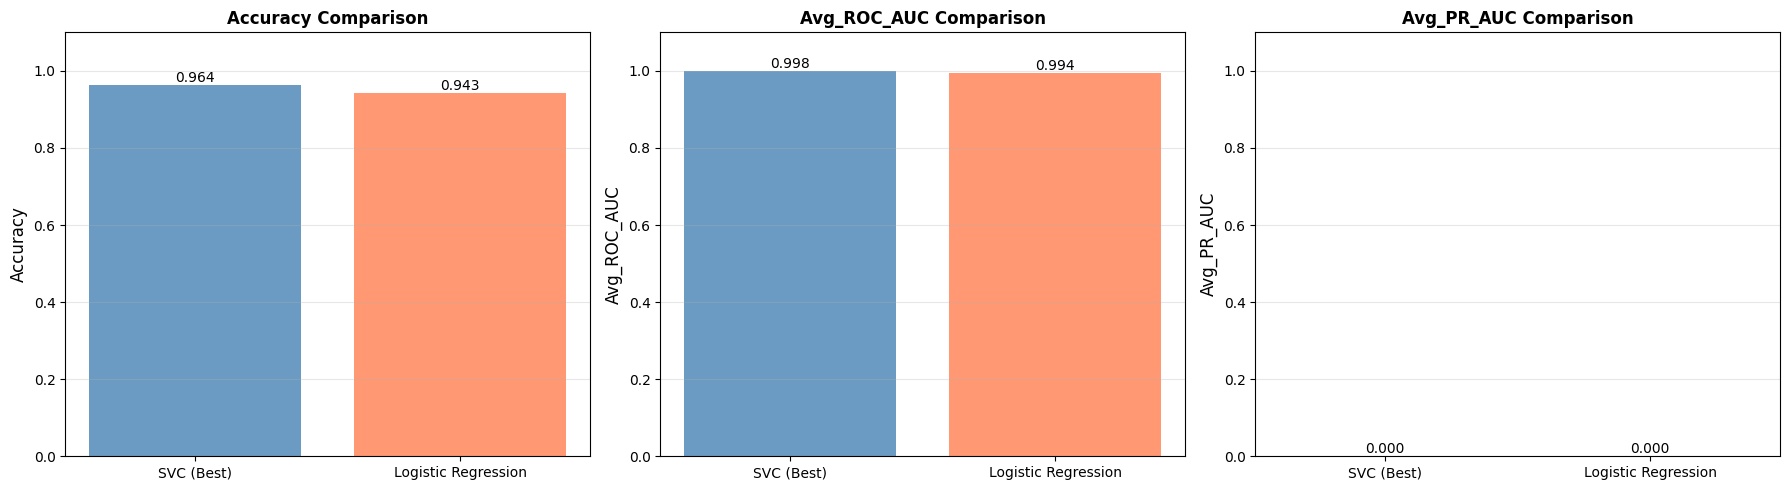

In [49]:
# Model Performance Summary

# Ensure test_predictions_lr is defined
try:
    _ = test_predictions_lr
except NameError:
    try:
        _ = logis_model
        print("Generating test predictions for Logistic Regression model...")
        test_predictions_lr = logis_model.predict(test_data_scaled)
    except NameError:
        # Create and train the model if it doesn't exist
        from sklearn.linear_model import LogisticRegression
        print("Creating and training Logistic Regression model...")
        logis_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
        logis_model.fit(train_data_scaled, train_data['fault'])
        print("Generating test predictions for Logistic Regression model...")
        test_predictions_lr = logis_model.predict(test_data_scaled)

# Get ROC and PR AUC values with fallback
try:
    avg_roc_auc_svc = np.mean(list(roc_auc_svc.values()))
except (NameError, AttributeError):
    avg_roc_auc_svc = 0.0

try:
    avg_roc_auc_lr = np.mean(list(roc_auc_lr.values()))
except (NameError, AttributeError):
    avg_roc_auc_lr = 0.0

try:
    avg_pr_auc_svc = np.mean(list(pr_auc_svc.values()))
except (NameError, AttributeError):
    avg_pr_auc_svc = 0.0

try:
    avg_pr_auc_lr = np.mean(list(pr_auc_lr.values()))
except (NameError, AttributeError):
    avg_pr_auc_lr = 0.0

performance_summary = pd.DataFrame({
    'Model': ['SVC (Best)', 'Logistic Regression'],
    'Accuracy': [
        accuracy_score(test_data['fault'], test_predictions_best),
        accuracy_score(test_data['fault'], test_predictions_lr)
    ],
    'Avg_ROC_AUC': [
        avg_roc_auc_svc,
        avg_roc_auc_lr
    ],
    'Avg_PR_AUC': [
        avg_pr_auc_svc,
        avg_pr_auc_lr
    ]
})

print("Model Performance Summary:")
print(performance_summary.to_string(index=False))

# Visualize performance comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Accuracy', 'Avg_ROC_AUC', 'Avg_PR_AUC']
for idx, metric in enumerate(metrics):
    ax = axes[idx]
    bars = ax.bar(performance_summary['Model'], performance_summary[metric], 
                  color=['steelblue', 'coral'], alpha=0.8)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1.1])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.3f}',
               ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


## Temuan Kunci dan Interpretasi

### Ringkasan Hasil Analisis SHAP

- Dua model utama: **SVC terbaik** (akurasi test 96,4%; 723/750 benar) dan **Regresi Logistik** (94,3%).
- Subset SHAP berisi 200 sampel seimbang (akurasi 98%) sehingga valid untuk eksplorasi global maupun lokal.
- Fitur yang dianalisis: max, min, mean, sd, rms, skewness, kurtosis, crest, dan form (semua dari sinyal getaran domain waktu).
- Fokus utama laporan: kepentingan fitur global, pola kerusakan spesifik, perbandingan strategi SVC vs LR, dan akar kesalahan klasifikasi.


### 1. Ringkasan Kepentingan Fitur
- **SVC** (akurasi 96,4% test / 98% subset SHAP) mengandalkan crest factor, min, dan skewness; bar stacked menunjukkan kontribusi antar kelas yang berbeda-beda → cocok untuk pola non-linear dan nilai ekstrem.
- **Regresi Logistik** (94,3%) menonjolkan mean, sd, rms, form; warna stacked relatif seragam karena pemanfaatan fitur yang konsisten → ideal untuk pemantauan baseline yang mudah dijelaskan.
- **Mean & Kurtosis** adalah satu-satunya fitur yang sama-sama penting di kedua model, sehingga dapat menjadi indikator universal kerusakan bearing.

### 2. Pola Spesifik Kerusakan
- **Inner Race**: Mean turun seiring keparahan, sehingga monitoring amplitudo paling efektif.
- **Outer Race**: Kurtosis + crest naik ketika kerusakan memburuk; perlu analisis bentuk distribusi.
- **Ball Fault**: Kombinasi mean + kurtosis stabil di semua tingkat; indikator gabungan sudah memadai.
- **Normal**: Membutuhkan campuran seimbang (kurtosis, rms, sd, mean) sebagai baseline referensi.

### 3. Perbandingan Model & Strategi
- SVC memberi akurasi tertinggi namun interpretasi lebih kompleks; LR lebih sederhana dan cukup kuat sebagai garis depan deteksi.
- Pendekatan **ensemble** dianjurkan: LR untuk alarm awal + interpretasi cepat, SVC untuk verifikasi mendalam pada kasus kritis.
- Pemilihan sensor: mean/SD/RMS cukup untuk LR, tetapi tambahkan crest/kurtosis agar SVC mendapat sinyal ekstrem.

### 4. Analisis Kesalahan
- Hanya 27/750 error di test penuh dan 4/200 di subset SHAP; seluruhnya terjadi pada kelas dengan keparahan mirip (0.014" vs 0.021").
- Tidak ada kebingungan lintas lokasi kerusakan → tambahkan fitur frekuensi atau indikator severity lanjutan untuk membedakan kasus borderline.

### 5. Rekomendasi Praktis
1. **Monitoring**: Jalankan LR untuk pengawasan real-time, panggil SVC ketika skor risiko tinggi.
2. **Fitur**: Kembangkan fitur domain frekuensi dan interaksi antar fitur top untuk meningkatkan pemisahan severity.
3. **Operasional**: Bangun dashboard SHAP agar tim maintenance bisa menelusuri kontribusi fitur dan mengonfirmasi anomali.
4. **Pengembangan**: Evaluasi ensemble/uncertainty quantification dan perluas validasi ke dataset bearing lain atau mesin berputar sejenis.
